# Introduction

Weather and climate are among the most important factors that affect agriculture especially crop production. There is no question that a long warm and dry spell would cause a stress on crops and possibly reduce the yield on harvest for many products. Similarly freezing weather or very heavy rain that cause runoff during growing season could possibly damage the seeds or the plants after emerging. There are several other weather events/conditions, some with obvious positive or negative effect and some with a net effect which depends on when and where they happen and which product is planted. However, even condisering the obvious factors, building a succesful statistical model for crop yield is challenging to say the least. This is because, the agro-climatic indicators are highly correlated while most of the machine learning algorithms requires non-colinearity. Moreover, finding a long enough measurement for crop yield and the climate variables for building a model using ML algorithms is difficult. 

**Goal:** Developing a methodology for building a predictive model for crop production yield using climate variables as predictors. 
* Soybeans production yield has a relatively constant trend through time. 
* The planting and harvesting seasons are almost same at each state it is produced. 
Thus, we can select only the growing season for agroclimatic variables and use states as a categorical.

** Warning:**
I am building an ecological (aggregated) model which may cause ecological fallacy if not interpreted properly. Read [this](https://en.wikipedia.org/wiki/Ecological_fallacy) for detailed explanations. The model will be built from panel data of state averages. Hence there are two level of aggregations:
1. Aggregation on the state level.
2. Aggregation over entire selected production zone for the soybeans which inlcude 4 different states due to regression of panel data of 4 states over 30 years.
The second aggregation is different from the first one. There is no spatial averaging (or summation) in the second step. All the states data are stacked on top of each other to built a panel data. States are included in the model as dummy variables. However, including dummy variables, while providing the model the ability to predict different yields at each state, does not let the coefficients of indpendent variables differ at each state. In a more realistic model, both the intercept and the slope should be allowed to differ for each state. On the other hand, such a model would be more complicated, such as mixed effect hierarchical model, and the 30 years of observation at state level would not be sufficient. In fact, the fact that that there is only 30 years of observation for each state is the only reason for building a panel data structure for this study.

In [2]:
import os
import cdsapi

import numpy as np
import pandas as pd
import pandas_profiling
import geopandas
import netCDF4
import xarray as xarr # pandas based library for 
            # labeled data with N-D tensors at each dimension
import salem

import matplotlib.pyplot as plt
%matplotlib inline 
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
from scipy.stats import norm, skew #for some statistics
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.tsatools import detrend

# EDA & Data Wrangling
In this work I use 3 different data sets from different sources with completely different structures to create a new data set with a new structure. 

Since All three data sets are raw the data exploration and data wrangling steps had to be mixed. Each data sets contains more information then needed in this work. 

## Preparing The Crop Production Data
Crop Data is obtained from: https://quickstats.nass.usda.gov/results/347988B6-8746-305D-9147-D1A31FE09FD2

For this study the yield of soy beans and corn grains will be modeled.

Here is the map that shows where these crops are produced
Source: https://www.nass.usda.gov/Charts_and_Maps/Crops_County/al-ha.php

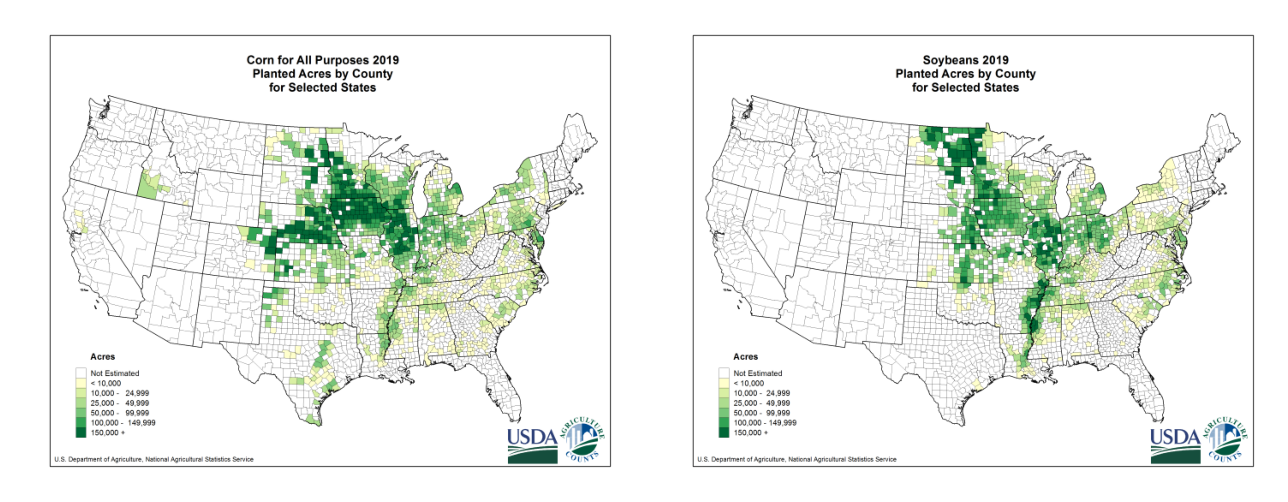

In [2]:
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

mpl.rc('figure', figsize = (18,12))
fig = plt.figure()
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
a = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/CR-PL-RGBChor.png")
ax1.imshow(a)

c = plt.imread("https://www.nass.usda.gov/Charts_and_Maps/graphics/SB-PL-RGBChor.png")
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(c)

for ax in [ax1,ax2]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
plt.tight_layout()
plt.show()
plt.close()

mpl.rcParams.update(mpl.rcParamsDefault)

<div class="span5 alert alert-info">
Crop production data contain various fields. The most important fields for this work are the State, Commodity, and the yield (Value). However, we do not need all the entries as some of them are irrelevant for our purpose or using them make it too complex for the scope of this work. Therefore, we will use most of the columns, even if we wouldn't need them eventually, to filter out those entries we want to get rid of.
</div>

In [5]:
#  Now Reading All the Crop Data that we are interested to a dataframe
path = "Data/"
# Let's read and merge all the crops data into a single dataframe
# This way data wrangling steps will be less cumbersome
files = [path+"Alfala.csv", path+"Corn.csv", path+"Soybean.csv"]
df = (pd.read_csv(f) for f in files)
df_crop = pd.concat(df, ignore_index=True)
df_crop.head(3).T

,0,1,2
Program,SURVEY,SURVEY,SURVEY
Year,2019,2019,2019
Period,YEAR,YEAR,YEAR
Week Ending,NaN,NaN,NaN
Geo Level,STATE,STATE,STATE
State,IDAHO,IDAHO,MONTANA
State ANSI,16,16,30
Ag District,NaN,NaN,NaN
Ag District Code,NaN,NaN,NaN
County,NaN,NaN,NaN


In [6]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Program           8522 non-null   object 
 1   Year              8522 non-null   int64  
 2   Period            8522 non-null   object 
 3   Week Ending       0 non-null      float64
 4   Geo Level         8522 non-null   object 
 5   State             8522 non-null   object 
 6   State ANSI        8522 non-null   int64  
 7   Ag District       0 non-null      float64
 8   Ag District Code  0 non-null      float64
 9   County            0 non-null      float64
 10  County ANSI       0 non-null      float64
 11  Zip Code          0 non-null      float64
 12  Region            0 non-null      float64
 13  watershed_code    8522 non-null   int64  
 14  Watershed         0 non-null      float64
 15  Commodity         8522 non-null   object 
 16  Data Item         8522 non-null   object 


We are not interested in most of these columns. The only relevant columns are these: `State`, `Commodity`, `Data Item`(that is the column associated with the Value column along with State colums), `Domain`, `Value` (This is what we are trying to predict). However, we might need to check them first to decide which rows to include for our model. 

* **Value column is object type. We need to convert it to Float.**
* Also Let's drop all other nan values. None of the columns we are interested in has any nan values.


In [7]:
f = lambda x: x.replace(',', '')
df_crop['Value'] = df_crop['Value'].apply(f)
# Before converting to numeric let's see if there is non-numeric values and what they are
def IsNumeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
S = lambda s: isinstance(s, (int, float))
_isdigit = df_crop['Value'].apply(IsNumeric)
_r = df_crop[~_isdigit]['Value'].value_counts()
print(f'There are {_r[0]} entries with the value of "{_r.index[0]}"' )

There are 156 entries with the value of " (D)"


**According to the [Quick Stats Glossary](https://quickstats.nass.usda.gov/src/glossary.pdf) published by USDA for this dataset "D" corresponds to:** 

> **Withheld to avoid disclosing data for individual operations.**

Thus all we can do is dropping these rows.


In [8]:
df_crop['Value'] = pd.to_numeric(df_crop['Value'], errors='coerce')
df_crop['Value'].isnull().sum()

156

<div class="span5 alert alert-info">
Now Let's drop all nan values together. Let's first check the with null values in the dataframe
    </div>

In [9]:
# Missing Values
nan=pd.DataFrame(df_crop.isnull().sum().sort_values(ascending=False), columns = ['NULL values'])
nan.query('`NULL values` > 0').T

,County ANSI,Ag District Code,Watershed,Week Ending,Region,Zip Code,County,Ag District,CV (%),Value
NULL values,8522,8522,8522,8522,8522,8522,8522,8522,7561,156


In [10]:
#first get rid of the nan values in Value column only
df_crop.dropna(subset=['Value'], inplace=True)

# Now we can drop all the columns with nan values at once
df_crop.dropna(axis=1, inplace=True)

# Fixing the index
df_crop.reset_index(drop=True, inplace=True)
print(df_crop.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Program          8366 non-null   object 
 1   Year             8366 non-null   int64  
 2   Period           8366 non-null   object 
 3   Geo Level        8366 non-null   object 
 4   State            8366 non-null   object 
 5   State ANSI       8366 non-null   int64  
 6   watershed_code   8366 non-null   int64  
 7   Commodity        8366 non-null   object 
 8   Data Item        8366 non-null   object 
 9   Domain           8366 non-null   object 
 10  Domain Category  8366 non-null   object 
 11  Value            8366 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 784.4+ KB
None


**There are some constant values and some entries we are not interested in. Let's remove them from the df_crop**

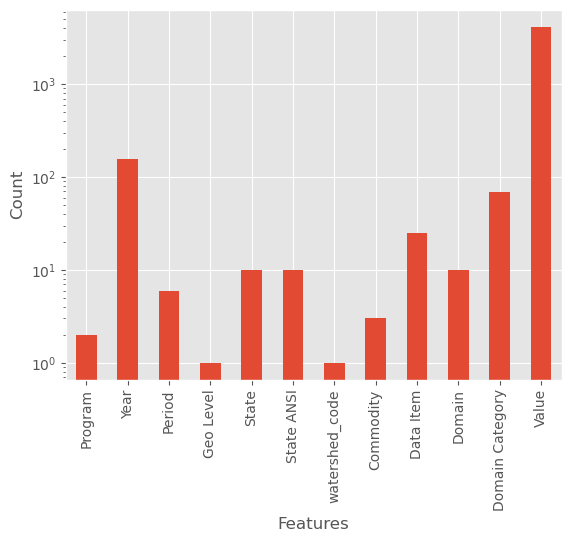

In [11]:
# First let's take a look at the number of unique 
# values in each column in a bar plot
plt.style.use('ggplot')
df_crop.nunique().plot(kind='bar', logy=True)
plt.xlabel('Features')
plt.ylabel('Count')
plt.show()
plt.close()
# Find those columns with constant values

**We need only Year entries for Period. Let's see what else is in there**

In [12]:
df_crop['Period'].value_counts()

YEAR                   6112
YEAR - AUG FORECAST     637
YEAR - OCT FORECAST     564
YEAR - SEP FORECAST     502
YEAR - NOV FORECAST     479
YEAR - JUN ACREAGE       72
Name: Period, dtype: int64

Looks like some values are just forecast entries not observations. We don't need any of those.

In [13]:
# dropping all rows with forecast entries given in Period column
mask_year = df_crop['Period'] == 'YEAR'
df_crop = df_crop[mask_year]
df_crop.reset_index(drop=True, inplace=True)
df_crop.nunique()

Program               2
Year                155
Period                1
Geo Level             1
State                10
State ANSI           10
watershed_code        1
Commodity             3
Data Item            25
Domain               10
Domain Category      69
Value              3937
dtype: int64

**Let's take a look at the Domain Catogories.**
* For this study some of the domains are irrelavant, like "ECONOMIC CLASS"
* Domain Catogories should be consistent among all "Data Item" values

<div class="span5 alert alert-info">
We have two sources of records which are given in the `Program` field. Let's check these resources.
    </div>

In [14]:
df_crop['Program'].value_counts()

SURVEY    4929
CENSUS    1183
Name: Program, dtype: int64

In [15]:
mask_DomCat = df_crop['Domain Category'] != 'NOT SPECIFIED'
print(df_crop[mask_DomCat].Commodity.value_counts())
print(df_crop[mask_DomCat].Program.value_counts())
df_crop[mask_DomCat]['Domain Category'].value_counts()

SOYBEANS    1119
Name: Commodity, dtype: int64
CENSUS    1119
Name: Program, dtype: int64


AREA HARVESTED: (500 TO 999 ACRES)       40
AREA HARVESTED: (250 TO 499 ACRES)       40
AREA HARVESTED: (1,000 OR MORE ACRES)    39
AREA HARVESTED: (100 TO 249 ACRES)       39
AREA HARVESTED: (50.0 TO 99.9 ACRES)     38
                                         ..
WATER SOURCE: (ON FARM SURFACE)           7
NAICS CLASSIFICATION: (1124)              7
NAICS CLASSIFICATION: (1113)              6
WATER SOURCE: (OFF FARM)                  6
NAICS CLASSIFICATION: (11191)             1
Name: Domain Category, Length: 68, dtype: int64

<div class="span5 alert alert-info">
There are 69 Domain Categories, but only Soybeans from CENSUS have Categories other than <code>NOT SPECIFIED</code>.
<b>Hence, for now I seperate all those Domain Categories to deal with them later since they require special handling.</b>

Note that these entries are from CENCUS records. Thus it is already more reasonable not to mix data from two different source <b>("Survey and Cencus")</b>
    </div>

In [16]:
# creating new dataframe for soybeans from CENSUS
df_soybean_census = df_crop[mask_DomCat]

# Crerating a new dataframe for Survey only crops
df_crop_srv = df_crop[~mask_DomCat]

# Let's see what commodities left in the df_crop_srv
df_crop_srv.Commodity.value_counts()

CORN        2685
HAY         1504
SOYBEANS     804
Name: Commodity, dtype: int64

In [17]:
df_crop_srv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 6111
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Program          4993 non-null   object 
 1   Year             4993 non-null   int64  
 2   Period           4993 non-null   object 
 3   Geo Level        4993 non-null   object 
 4   State            4993 non-null   object 
 5   State ANSI       4993 non-null   int64  
 6   watershed_code   4993 non-null   int64  
 7   Commodity        4993 non-null   object 
 8   Data Item        4993 non-null   object 
 9   Domain           4993 non-null   object 
 10  Domain Category  4993 non-null   object 
 11  Value            4993 non-null   float64
dtypes: float64(1), int64(3), object(8)
memory usage: 507.1+ KB


<div class="span5 alert alert-info">
Still there are more columns than we need. Let's drop the ones we will not use. <b>We do not need constant value columns</b>
    </div>

In [18]:
# Getting rid of the columns with constant values
nunq = df_crop_srv.nunique()
dropped = []
for clm in df_crop_srv:
    if nunq.loc[clm] == 1:
        df_crop_srv = df_crop_srv.drop(clm, axis=1)
        dropped.append(clm)
print(df_crop_srv.nunique(),'\n\n')
print(f'dropped columns: {dropped}')

Program          2
Year           155
State           10
State ANSI      10
Commodity        3
Data Item       21
Value         2960
dtype: int64 


dropped columns: ['Period', 'Geo Level', 'watershed_code', 'Domain', 'Domain Category']


In [19]:
# Now fixing the index
df_crop_srv = df_crop_srv.reset_index(drop=True)
df_crop_srv.sample(3)

,Program,Year,State,State ANSI,Commodity,Data Item,Value
4506,SURVEY,1989,IOWA,19,SOYBEANS,"SOYBEANS - YIELD, MEASURED IN BU / ACRE",39.0
3148,SURVEY,1935,NEBRASKA,31,CORN,"CORN, GRAIN - ACRES HARVESTED",6866000.0
1488,SURVEY,1920,IDAHO,16,HAY,"HAY, ALFALFA - PRODUCTION, MEASURED IN TONS",1912000.0


Let's select the soybeans yield data only

In [20]:
df_crop_srv[df_crop_srv['Commodity']=='SOYBEANS']['Data Item']

4189                SOYBEANS, IRRIGATED - ACRES HARVESTED
4190    SOYBEANS, IRRIGATED - WATER APPLIED, MEASURED ...
4191    SOYBEANS, IRRIGATED - YIELD, MEASURED IN BU / ...
4192                SOYBEANS, IRRIGATED - ACRES HARVESTED
4193    SOYBEANS, IRRIGATED - WATER APPLIED, MEASURED ...
                              ...                        
4988              SOYBEANS - YIELD, MEASURED IN BU / ACRE
4989                           SOYBEANS - ACRES HARVESTED
4990              SOYBEANS - YIELD, MEASURED IN BU / ACRE
4991                           SOYBEANS - ACRES HARVESTED
4992              SOYBEANS - YIELD, MEASURED IN BU / ACRE
Name: Data Item, Length: 804, dtype: object

In [21]:
# getting the only soybeans - yield rows
soybeans_mask = df_crop_srv['Data Item'] == \
    "SOYBEANS - YIELD, MEASURED IN BU / ACRE"
df_soy = df_crop_srv[soybeans_mask].reset_index(drop=True)

# Preparing the Agroclimatic Geospatial Time Series Data
<table class="abstract-description abstract-table">
        <tbody><tr><th colspan="2">DATA DESCRIPTION</th>
        
</tr><tr><th>Data type</th><td>Gridded</td></tr>
<tr><th>Projection</th><td>Regular latitude-longitude grid</td></tr>
<tr><th>Horizontal coverage</th><td>Global</td></tr>
<tr><th>Horizontal resolution</th><td>0.5° x 0.5°</td></tr>
<tr><th>Vertical coverage</th><td>Surface</td></tr>
<tr><th>Vertical resolution</th><td>Single level</td></tr>
<tr><th>Temporal coverage</th><td>1951 to 2099</td></tr>
<tr><th>Temporal resolution</th><td>Variable dependent: 10-day, seasonal or annual</td></tr>
<tr><th>File format</th><td>NetCDF-4</td></tr>
<tr><th>Conventions</th><td>Climate and Forecast (CF) Metadata Convention v1.7</td></tr>
<tr><th>Update frequency</th><td>No updates expected</td></tr>
</tbody></table>


 #### Download the data using CDSAPI

In [22]:
# # This cell needs to be run only once, when the agroclimatic indicators are downloaded from the source

# c = cdsapi.Client()

# c.retrieve(
#     'sis-agroclimatic-indicators',
#     {
#         'origin': 'era_interim_reanalysis',
#         'variable': [
#             'biologically_effective_degree_days', 'frost_days', 'heavy_precipitation_days',
#             'ice_days', 'maximum_of_daily_maximum_temperature', 'maximum_of_daily_minimum_temperature',
#             'mean_of_daily_maximum_temperature', 'mean_of_daily_mean_temperature', 'mean_of_daily_minimum_temperature',
#             'mean_of_diurnal_temperature_range', 'minimum_of_daily_maximum_temperature', 'minimum_of_daily_minimum_temperature',
#             'precipitation_sum', 'simple_daily_intensity_index', 'summer_days',
#             'tropical_nights', 'very_heavy_precipitation_days', 'wet_days',
#         ],
#         'experiment': 'historical',
#         'temporal_aggregation': '10_day',
#         'period': '198101_201012',
#         'format': 'zip',
#     },
#     'download.zip')

#### Reading data as an Xarray dataset
The agroclimatic data is a gridded time series data. It comes as a Netcdf file, which contains the latitude, longtitude and altitude coordinates and time dimension as well as 26 agroclimatic indicators. Although pandas data frame can be used to import this data, it would be too cumbersome to do so due to unusual structure of the data. Xarray library on the other hand is built exactly for handling this type of dataset.

In [3]:
# Read the data Path where they are stored on the Computer
#data_dir = input('Path to the data\n')
paths = []
for folder in ['dekadal', 'seasonal', 'annual']:
    paths += [os.path.join('C:\\'
                'Users',
                'kurt_',
                'Data',
                'agroclimate',
                 folder,'')]
dekadal_dir, seasonal_dir, annual_dir = paths

#### Importing the Indicators
<div class="span5 alert alert-info">
Each agroclimatic indicator is stored in the disk as a single netcdf file. <b>All the files will be merged into a single xarray dataset which will be divided into chunks and parallelization with dask will be enabled to speed up the operations</b>
</div>

In [4]:
# Import data as xarray dataset from the directory
def read_nc_files(data_dir, chunk, dask=False):
    dask = True
    if dask:
        # Import with dask
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                                  combine='by_coords', 
                                 chunks= chunk, # first spatial subsetting operations will be made.
                                 engine='netcdf4') # if available, h5netcdf engine is fatser than netcdf4
    else:
        # Import without dask for debugging
        dt = xarr.open_mfdataset(data_dir+'*hist*.nc', parallel=True, 
                              combine='by_coords', engine='netcdf4')
    return dt
clim_dek = read_nc_files(dekadal_dir, chunk={'time':20}, dask=True) # The size on the disk is 2.4gb
clim_seas = read_nc_files(seasonal_dir, chunk=None)
clim_ann = read_nc_files(annual_dir, chunk=None)

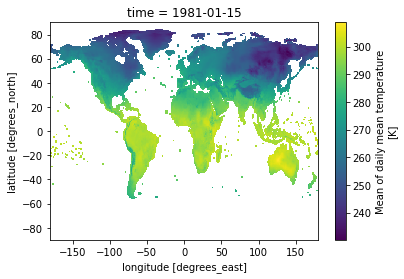

In [7]:
clim_dek['TG'].isel(time=1).plot()
# plt.show()
plt.savefig('Figures/World.png')

#### Selecting U.S.
Since the final model will only apply to some continental U.S. states, there is no need to work on global data. Removing the rest of the world's data significantly reduces memory demand.

In [164]:
# selecting U.S. only
clim_dek = clim_dek.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_seas = clim_seas.sel(lon=slice(-140, -50) ,lat=slice(15,60))
clim_ann = clim_ann.sel(lon=slice(-140, -50) ,lat=slice(15,60))

# Write them to disk and re-read them without chunks
ds_dict = {'dekadal':clim_dek, 'seasonal': clim_seas,
           'annual': clim_ann}
for ds_key in ds_dict:
    # write the data into folders with paths dek_dir, seas_dir or ann_dir 
    ds_dict[ds_key].to_netcdf(f'{eval(ds_key+"_dir")}{ds_key}.nc')

In [165]:
# Reading the us data from the disk
clim_dek = xarr.open_dataset(dekadal_dir+"dekadal.nc", chunks={'time':135})
clim_seas = xarr.open_dataset(seasonal_dir+"seasonal.nc")
clim_ann = xarr.open_dataset(annual_dir+"annual.nc")

### Exploring the agroclimatic indicators datasets

In [166]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [172]:
clim_dek['TG'].isel(time=1)

<xarray.DataArray 'TG' (lat: 90, lon: 180)>
dask.array<getitem, shape=(90, 180), dtype=float32, chunksize=(90, 180), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1981-01-15
  * lat      (lat) float64 15.25 15.75 16.25 16.75 ... 58.25 58.75 59.25 59.75
  * lon      (lon) float64 -139.8 -139.2 -138.8 -138.2 ... -51.25 -50.75 -50.25
Attributes:
    units:         K
    long_name:     Mean of daily mean temperature
    cell_methods:  time: mean

In [167]:
def plot_2d(var, time):
    # ploting the first time step to check the selected area
    ax = clim_dek[var].isel(time=time).plot(figsize=(10,5))
    plt.show()
    return ax
interact(plot_2d, var=[i for i in clim_dek if i!= 'time_bounds'], time=(1,1080,36))

interactive(children=(Dropdown(description='var', options=('BEDD', 'DTR', 'FD', 'ID', 'R10mm', 'R20mm', 'RR', …

<function __main__.plot_2d(var, time)>

In [29]:
def explore_ds(dt):
    for var in dt:
        print(f'{var}: {dt[var].attrs}')
    # Let's select the first time step and plot the 2m-air temperature

    # Let's check the dimensions
    for dim in dt.dims:
        dimsize = dt.dims[dim]
        print(f'\nData has {dimsize} {dim} ')
        if dim == 'latitude':
            print(f' latitudes: from {float(dt[dim].min())} degree South',
         f'to {float(dt[dim].max())} degree North')
        if dim == 'longitude':
            print(f' Longitudes: from {float(dt[dim].max())} degree East',
         f'to {float(dt[dim].min())} degree West')
        if dim == 'time':
            print(f'time: from {pd.to_datetime(dt["time"].min().values)} to\
                  {pd.to_datetime(dt["time"].max().values)} ')

#### Dekadal variables

In [30]:
explore_ds(clim_dek)

time_bounds: {}
BEDD: {'units': 'degrees_C', 'long_name': 'Biologically Effective Degree Days', 'cell_methods': 'time: sum'}
DTR: {'units': '', 'long_name': 'Mean of diurnal temperature range', 'cell_methods': 'time: mean'}
FD: {'units': 'day', 'long_name': 'Frost days (minimum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
ID: {'units': 'day', 'long_name': 'Ice days (maximum temperature < 0 degrees_C)', 'cell_methods': 'time: sum'}
R10mm: {'units': 'day', 'long_name': 'Heavy precipitation days (precipitation >= 10 mm)', 'cell_methods': 'time: sum'}
R20mm: {'units': 'day', 'long_name': 'Very heavy precipitation days (precipitation >= 20 mm)', 'cell_methods': 'time: sum'}
RR: {'units': 'mm', 'long_name': 'Precipitation sum', 'cell_methods': 'time: sum'}
RR1: {'units': 'day', 'long_name': 'Wet days (precipitation >= 1 mm)', 'cell_methods': 'time: sum'}
SDII: {'units': 'mm', 'long_name': 'Simple daily intensity index for wet days (mm/wet day)', 'cell_methods': 'time: mean'}
SU:

Dekadal dataset have 2 spatial, one time coordinates and 15 variables. Now let's see what each of these variables are.

#### Seasonal variables

In [31]:
explore_ds(clim_seas)

time_bounds: {}
CDD: {'units': 'day', 'long_name': 'Maximum number of consecutive dry days (precipitation < 1 mm)', 'cell_methods': 'time: maximum'}
CFD: {'units': 'day', 'long_name': 'Maximum number of consecutive frost days (minimum temperature < 0 degrees_C)', 'cell_methods': 'time: maximum'}
CSDI: {'units': 'day', 'long_name': 'Cold-spell duration index', 'cell_methods': 'time: sum'}
CSU: {'units': 'day', 'long_name': 'Maximum number of consecutive summer days(temperature > 25 degrees_C)', 'cell_methods': 'time: maximum'}
CWD: {'units': 'day', 'long_name': 'Maximum number of consecutive wet days (precipitation >= 1 mm)', 'cell_methods': 'time: maximum'}
WSDI: {'units': 'day', 'long_name': 'Warm-spell duration index', 'cell_methods': 'time: sum'}
WW: {'units': 'day', 'long_name': 'Warm and wet days', 'cell_methods': 'time: sum'}

Data has 2 bounds 

Data has 90 lat 

Data has 180 lon 

Data has 119 time 
time: from 1981-04-16 00:00:00 to                  2010-10-16 00:00:00 


Seasonal dataset have 2 spatial, one time coordinates and 7 variables. Now let's see what each of these variables are.

#### Annaul variable

In [32]:
explore_ds(clim_ann)

time_bounds: {}
GSL: {'units': 'day', 'long_name': 'Growing season length', 'cell_methods': 'time: sum'}

Data has 2 bounds 

Data has 90 lat 

Data has 180 lon 

Data has 30 time 
time: from 1981-07-01 00:00:00 to                  2010-07-01 00:00:00 


There is only a single annual variable.

#### Droping variables Not Needed
<div class="span5 alert alert-info">
Some of these variables are related to variation in the climate. However, in this study trend in climate variables will be removed and climate change is not studied. Hence some of these variables will be removed.
    </div>

In [33]:
# create a list of variables to keep
vars_to_keep = ['BEDD', 'CSDI', 'FD', 'GSL', 'R10mm', 
        'ID', 'CDD','CFD', 'CSU', 'CWD', 'TX',
       'TG', 'DTR', 'RR', 'SU', 'TR', 'R20mm',
       'WW', 'WSDI', 'RR1']
# Drop all but these variables in the vars_to_keep
def DropVars(ds):
    for var in ds:
        if var not in vars_to_keep:
            ds = ds.drop_vars(var)
    return ds
    
clim_dek = DropVars(clim_dek)

## Merging All Climate Datasets 
**(Dekadal, Seasonal, Annual)**

<div class="span5 alert alert-warning">
<ul> <li>Some variables are aggregated as sum of all the occurence  during default time interval (10 days), while some are averaged.</li> 
    <li>The aggregation method is recorded in "cell_methods" attribute of the variable.</li> 
    <li>Using cell_methods for each variable annual aggregations will be calculated.</li>
    <li>All three datasets will be merged into a single one.</li>
    <li>Then, All the climate parameters will be spatially averaged through the state level.</li></ul>
</div>

#### Resampling Dekadal Variables
**The planting season roughly start on May and the harvesting ends before December at each state. The only climate variables relavant is in this range in each year. Therefore, let's select only this months and then yearly resample all the variables**

Let's define a function to resample the datasets. Resample method for each variable should be choosen from it's cell_method, which tells how the variable is agregated through time. 

In [34]:
def resample_with_cell_method(ds, frq='AS'):
    """Resample the input dataset to a frequency given as frq as input
    with resampling method unique for each variable, in accordance with 
    their cell method, how they originally aggregated """

    # Resampling annualy
    ds_resampled = ds.resample(time=frq, keep_attrs=True)
    
    # creating a list to merge indpendently resampled variables
    dt_arrays_to_merge = []

    # iterate over each variable
    for var in ds:
        # skip time_bounds variable
        if var == "time_bounds":
            continue
        # resampling method based on each variable's cell_method
        if "mean" in ds[var].cell_methods:
            vars()[var] = ds_resampled.mean(keep_attrs=True)[var]
        elif "maximum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.max(keep_attrs=True)[var]
        elif "minimum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.min(keep_attrs=True)[var]
        elif "sum" in ds[var].cell_methods:
            vars()[var] = ds_resampled.sum(keep_attrs=True)[var]
        # appending resampled variable to the list
        dt_arrays_to_merge.append(eval(var))

    # Merge all variables back to a dataset
    return xarr.merge(dt_arrays_to_merge)

In [35]:
# Selecting the relavant months in each year
sel_dates = clim_dek.time.values[(clim_dek.time.dt.month > 4) & (clim_dek.time.dt.month < 12)]
clim_dek_subset = clim_dek.sel(time=sel_dates)

In [36]:
clim_dek_to_ann = resample_with_cell_method(clim_dek_subset)
clim_dek_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

The dekadal data is now downsampled to yearly data.

#### Resampling Seasonal Variables
We need the data for the months covering May - November. Either Spring, Summer and Fall should be selected to cover all the growing season or we could just select summer and Fall, since the values agregated through March and April should have no affect on the soybean production, and yet they are included in the spring data. Besides, none of the southern states, where the planting season starts earlier, included in the soybean yield data. For the states included in the data, the most active planting season usualy starts near the end of the May <b style="color:red">*</b>.

Thus, I will only select summer and fall seasons for the afferomentioned reasons 

<b style="color:red">\*Source:</b> https://swat.tamu.edu/media/90113/crops-typicalplanting-harvestingdates-by-states.pdf

In [37]:
# Selecting the summer and fall seasons in each year
sel_dates = clim_seas.time.values[clim_seas.time.dt.month >= 7]
clim_seas_subset = clim_seas.sel(time=sel_dates)

In [38]:
clim_seas_to_ann = resample_with_cell_method(clim_seas_subset)
clim_seas_to_ann.dims

Frozen(SortedKeysDict({'time': 30, 'lat': 90, 'lon': 180}))

#### Merging all three datasets
Now that the dekadal and seasonal datasets are resampled annually, they can be merged into a single dataset holding all the agro-climatic indicators.
Note that clim annual index is a bit different. Each years sample recorded on july, while they are recorded on the first month in the other datasets. Let's first fix it. Then merge all the datasets.

In [39]:
clim_ann.time.values[:5]

array(['1981-07-01T00:00:00.000000000', '1982-07-01T00:00:00.000000000',
       '1983-07-01T00:00:00.000000000', '1984-07-01T00:00:00.000000000',
       '1985-07-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [40]:
# fix the time dimension in clim_ann to match the others
clim_ann['time'] = clim_seas_to_ann['time']
clim_ann.time.values[:5]

array(['1981-01-01T00:00:00.000000000', '1982-01-01T00:00:00.000000000',
       '1983-01-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1985-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

This has resulted to partition the data to more chunks, but it doesn't matter as in the next part the combined dataset will be saved to disk, then reread with chunks on spatial dimensions, as the time dim has length of only 30 now.

In [41]:
# Combine all the data to agro_clim dataset
agro_clim = xarr.merge([clim_dek_to_ann, clim_seas_to_ann, clim_ann])
# Let's save agro_clim to disk. This will save time when repeating the work
agro_clim.to_netcdf('C:\\Users\\kurt_\\Data\\agro_clim.nc')

C:\Users\kurt_\Anaconda3\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Because some grids' are on water surface they are nan. This causes the warning `invalid value encountered` in divide. Though, it is possible to avoid it, it has no impact on the region we are interested in. 

In [82]:
del agro_clim

In [6]:
agro_clim = xarr.open_dataset('C:\\Users\\kurt_\\Data\\agro_clim_test1.nc')

In [19]:
def grid_mean(ds):
    """lat-lon mean of the entire dataset
    accounting for the actual grid areas"""
    weight = np.cos(np.deg2rad(ds.lat))
    cos_lat_weighted_mean = ds.weighted(weight).mean(("lon", "lat"))

    return cos_lat_weighted_mean


def anomaly(da):
    """calculate anomaly"""

    clim = da.mean(dim='time')
    anom = da - clim

    return anom

def covmat(a,b):
    """covmat(a,b): calculate covariance between vector a and each grid point of matrix b
     returns a matrix with dimensions of b"""

    b1 = b.values
    s1 = np.shape(b1)
    a1 = a.values
    b1 = b1.reshape(s1[0],s1[1]*s1[2])

    a1 = a1 - np.average(a1);
    b1 = b1 - np.average(b1,axis=0)

    c1 = np.matrix(a)*np.matrix(b1)
    c1 = c1.reshape(s1[1],s1[2])/s1[0]
    c1 = xarr.DataArray(c1,dims=['lat','lon'],coords={'lat': b.lat, 'lon': b.lon})

    return c1


def detrend_2d(da):
    """linear detrend of 2D data set (lat x lon x time)
    returns anomaly"""

    da1 = anomaly(da)

    t1 = xarr.DataArray(np.arange(len(da1.time)),dims='time',coords={'time': da1.time})
    slope = covmat(t1,da1)/np.std(t1)**2

    da1 -= slope*t1 # remove linear trend
    da2 = anomaly(da1)

    return da2

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [86]:
def plot_spatial_mean(var='TG',time=1, detrending=True, spatial_mean = True):
    """Plot the spatial mean of anomalies of variables after detrending them"""
    fig, ax = plt.subplots(figsize=(8,5))
    if detrending == True:
        if spatial_mean == True:
            if var == 'Yield':
                print('No spatial data for Yield') 
            else:
                grid_mean(detrend_2d(agro_clim[var])).plot(marker='.', ax=ax)
                plt.title(agro_clim[var].long_name)
        elif spatial_mean == False:
            if var == 'Yield':
                dt = detrend(df_soy.query('Year > 1945')['Value'])
                dt.index = df_soy.query('Year > 1945').Year
                dt.plot(ax=ax)
            else:
                detrend_2d(agro_clim[var]).isel(time=time).plot(ax=ax)
                plt.title(agro_clim[var].long_name)
        else: 
            raise TypeError('spatial_mean should be "True" or "False"')
    elif detrending == False:
        if spatial_mean == True:
            if var == 'Yield':
                print('No spatial data for Yield') 
            else:
                grid_mean(agro_clim[var]).plot(marker='.', ax=ax)
                plt.title(agro_clim[var].long_name)
        elif spatial_mean == False:
            if var == 'Yield':
                df_soy.query('Year > 1945').plot(x='Year', y='Value',ax=ax)
            else:
                agro_clim[var].isel(time=time).plot(ax=ax)
        else: 
            raise TypeError('spatial_mean should be "True" or "False"')
    else:
        TypeError('detrending should be "True" or "False"')
    return fig, ax

In [87]:
variables = [i for i in agro_clim.data_vars if i !='time_bounds']
variables.append('Yield')
interact(plot_spatial_mean, var=variables, time=(0,29,1))
plt.show()

interactive(children=(Dropdown(description='var', index=9, options=('BEDD', 'DTR', 'FD', 'ID', 'R10mm', 'R20mm…

### Detrending Agro-Climatic Indicators (Features)
<div class="span5 alert alert-info">
The priority of this project is to investigate how crop yield is affected by weather conditions. Therefore interannual variability in yield is more important for this work than decadal variability where the latter is related not only Climate but also development in agricultural technologies and human beheviours.
    <p>Therofore, I will first detrend the predictors (agro-climatic indicators) and later the response variable (yield).</p>
    </div>

In [157]:
# applying detrend_2d function on all the variables in agro_clim dataset
agro_clim = agro_clim.map(detrend_2d, keep_attrs=True)

## Getting Climate For Product Zone
* Importing US-Census geospatial data for the state boundaries using __Geopandas package__ https://catalog.data.gov/dataset/u-s-county-boundaries
* Embedding state coordinates to Xarray climate dataset for state-wise operations. 
* Masking climate dataset only to keep the relavant states using **Salem package**

In [89]:
# Read the shape file for US States using Geopandas package
path_geo = 'C:\\Users\\kurt_\\Data\\usstates\\'
geo_usa = geopandas.read_file(path_geo)
print(type(geo_usa))
print('The coordinate Reference System Info:')
print(geo_usa.crs)
geo_usa.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
The coordinate Reference System Info:
epsg:4269


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


<div class="span5 alert alert-info">
Now the fun part:<br> We have coordinates of US state boundaries in the geo_usa data, let's plot the mainland US on a map based on these coordinates to see if everyhting is alright.
    </div>

Double Click To Zoom In


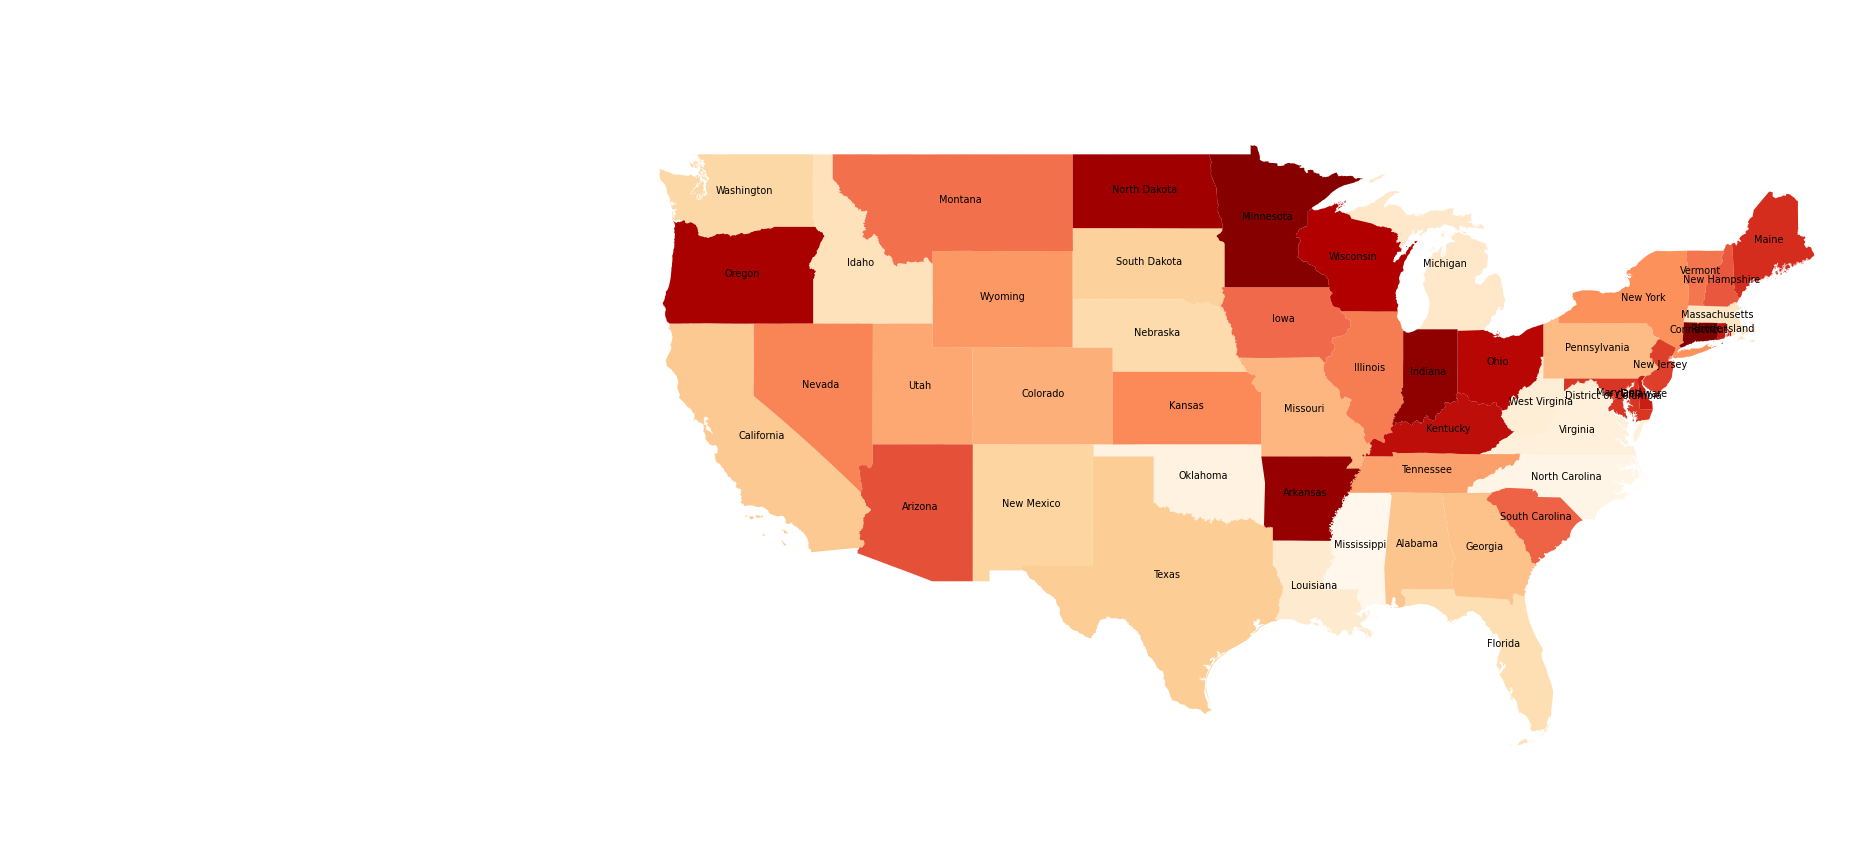

In [90]:
# Let's see the state boundaries on a map to see
# if there is an error

#Double click to zoom in
red = '\033[31;2;7m'
reset = '\033[0m'
print(red+"Double Click To Zoom In"+reset)

# Getting rid of oversees territories from the map
geo_usa = geo_usa[geo_usa.STATEFP.apply(lambda x: int(x)) < 60]
#Let's remove the Alaska too
geo_usa = geo_usa[geo_usa.NAME != 'Alaska']
fig,ax = plt.subplots(figsize=(16, 12))
geo_usa.plot(ax=ax, cmap='OrRd')
ax.set_xlim(-127,-65)
ax.set_ylim(22,55)
ax.set_yticks([])
ax.set_xticks([])
ax.axis("off")
geo_usa.apply(lambda x: ax.annotate(text=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7),axis=1);
# plt.tight_layout()
plt.show()
plt.close()

#### Calculating State Means
<div class="span5 alert alert-info">
    <ul><li> Define a function to calculate state-wise spatial means for selected crops.</li>
    This will reduce the space-time data to a simple time-series for each state.
    <li>Then let's plot 2-d temperature variable of the states on a random day to make sure that everything is fine.</li>
</div>

In [9]:
def sel_states(dt, crop, file_path, var=None, states='all', _plot=False):
    """Calculate state climate and Plot the region of interest from 
    the list of 'state' list. 
    var: which variable to plot. kywrd:
            Default = None: Do not plot any variables. if _plot=True a variable name has to be given intead
    state: which state to select. Default is 'all': all the states in df_crop 
            'crop': only the states for the selected crop
            state_name: Manually select states. State names should be a list of strings """
    # Getting State names
    if states not in ['all', 'crop']: # user selected states
        crop_states = [states.title()]  # just convert to upper case
    elif states == 'all':
        crop_states = list(df_crop_srv.State.unique())
        crop_states = [x.title() for x in crop_states]
    elif states == 'crop':
        crop_states = list(df_crop_srv[df_crop_srv['Commodity'] == crop]
                           .State.unique())
        crop_states = [x.title() for x in crop_states]
#     print(f'{crop} states: {crop_states}')
    # Reading state shape files from census data using Salem
    us_states = salem.read_shapefile(file_path)
    state_coord = us_states[(us_states.NAME.isin(crop_states))]

    # Extracting only the region of interest from climate data
    state_clim = dt.salem.subset(shape=state_coord, 
                                 margin=5).salem.roi(shape=state_coord)
    
    # plotting the region of interest
    if _plot == True:
        plt.style.use('seaborn-colorblind')

        # Creating Figures
        fig = plt.figure(figsize=(8,6))

        # plotting on a map using cartopy
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
        ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
        ax.add_feature(cartopy.feature.RIVERS)
        ax.add_feature(cartopy.feature.STATES)

        # State names on the map
        state_coord.apply(lambda x: ax.annotate(text=x.NAME, 
                                                xy=x.geometry.centroid.coords[0], 
                                                ha='center', fontsize=7),axis=1);

        # Let's plot the variable at a random time
        randm_day = state_clim[var].isel( time=
                                         np.random.randint(len(state_clim.time)))

        # randm_day.salem.roi(shape=state_coord).plot(ax=ax)
    #     randm_day = randm_day.salem.roi(shape=state_coord)
        plt.pcolormesh(randm_day.lon, randm_day.lat, randm_day)

        cb = plt.colorbar(shrink=0.4) # use shrink to make colorbar smaller
        cb.set_label(f"{dt[var].long_name} in {dt[var].units}")

        plt.title(f'{crop} States')
    return state_clim
# let's see the sel_states function to get and plot the states where soybeans are grown
coord_file = path_geo+'cb_2018_us_state_500k.shp'
state_clim = sel_states(agro_clim,crop='SOYBEANS', 
                        file_path = coord_file,var='CWD', states='crop', _plot=True)
# plt.show()

#### Converting Xarray datasets to DataFrames
* Using `sel_states` function those states where soybeans are grown will be selected individually
* `spatial_mean` function will be used to take the proper spatial mean of each state along lat-lon dims.
    (This will produce a simple time series data for each state.)
* All the datasets will be converted to a dataframe
* from df

In [156]:
soy_states = list(df_crop_srv[df_crop_srv['Commodity'] == "SOYBEANS"]
                       .State.unique())

state_clim_list = []
for state in soy_states:
    state_clim = sel_states(agro_clim,
                            crop='SOYBEANS', states=state)
    
    # Calculate correct spatial mean for the state
    state_clim = grid_mean(state_clim) # only dimension is time now
    
    # convert the state_clim to a dataframe
    state_clim = state_clim.to_dataframe()
    
    # add state name as a new column    
    # fill the State column with ones
    state_clim['State'] = np.ones(len(state_clim))
    
    # replace the ones with the state name
    state_clim['State'].replace(1, state, inplace=True)

    # collect state-mean datasets in a list to unpack later
    state_clim_list.append(state_clim)
    
# let's name each data set in the state_clim_list by their corresponding state name abbrevition
il_agro_clim, in_agro_clim, ia_agro_clim, nd_agro_clim =  state_clim_list
# let's concat all the states data in clim_ind (short for climate indicators)
clim_ind = pd.concat(state_clim_list, axis=0)

NameError: name 'df_crop_srv' is not defined

# Feature Engineering
The main problem in this data set is that there are only 30 observations, and as of this far, 20 agro-climatic indicators likely with high colinearity. To deal with this problem the following steps will be applied in this part
* Using simple techniques and domain knowledge only some of the most important columns will be selected as predictor variables. 
* Each of the four states' data will be stacked on top of each other. This data structure is called **panel data**<br>
    **The advantages of this method:**
    1. Sample size will increase to 120. <br>
    2. We can split the data to train and test and still do cross validation with the train data
    **The disadvantages of this method:**
     1. Since the each states' climate data is annually sampled, spatially averaged and detrended they are similar to each other ( see the plot below). Thus stacking them on top of each other is similar, to an extend, to repeating the 30 year-observation 4 times in the same data. The difference between the states could be from noise (impossible to model per se), difference in the affect of the climate variables on soybeans yield in each state. The former can be implemented in a model by one-hot encoding the states. The similarities between the observations at each states can be implented as autocorrelations with lag=30yr. This requires special regression methods such as mixed effect model. However, the lenght of the data we have is too short for such a complex model. 
     2. One-hot encoding will create 3 more features. Since the climate variables are similar in each state as explained above modeling the difference is difficult and normally requires large sample size. 

     Despite these drawbacks, the benefits of creating panel data outwiegh the downsides.
  

## Preparing Yield data for modelling
* Detrend the Yield data for each state
* Concact the detrended state data back to a dataframe
* Select the years matching climate data
* merge all climate and yield data together

<a id='PrepareYieldModelling'></a>

In [152]:
from scipy.stats import norm, skew #for some statistics
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.tsatools import detrend

In [93]:
# creating new dataframe for soybeans with the structure matching climate data
soy_yield = df_soy.sort_values(['State','Year'])
soy_yield.reset_index(inplace=True, drop=True)

Detrending before splitting the data to train and test is fine since this study is only about anomalies after all the trends are removed. This wouldn't cause any significant data leakage because trends in the data are mostly related to external factors such as technological development, human behaviours etc. rather than climate change which happens to have similar trend (although not by chance, they do not have direct cause and effect relationship in the context of crop yield).

In [94]:
# Select years matching clim_ind 
year_first = clim_ind.index[0].year
year_last = clim_ind.index[-1].year
soy_yield = soy_yield[(soy_yield.Year >= year_first) & 
                      (soy_yield.Year <= year_last)]

# detrending each state separately
df_list = []
for state in soy_states:
    df = soy_yield.query('State == @state').copy()
    df.loc[:,'Value'] = detrend(df['Value']).values
    df_list.append(df)
il_yield, in_yield, ia_yield, nd_yield = df_list
# collect all states crop data into one
soy_yield = pd.concat(df_list, axis=0)

interactive(children=(Dropdown(description='var', options=('TG', 'RR1', 'SU'), value='TG'), Output()), _dom_cl…

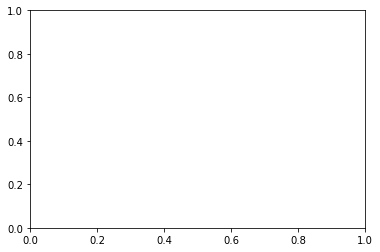

In [155]:
def plot_var(var):
    fig, ax = plt.subplots()
    for df in state_clim_list:
        df[var].plot(ax=ax)
        plt.title(agro_clim[var].long_name)
        
interact(plot_var, var=['TG','RR1','SU']) # clim_ind.columns.values
plt.show()
#interact plots don't appear on github
# plot_var('GSL')

<AxesSubplot:>

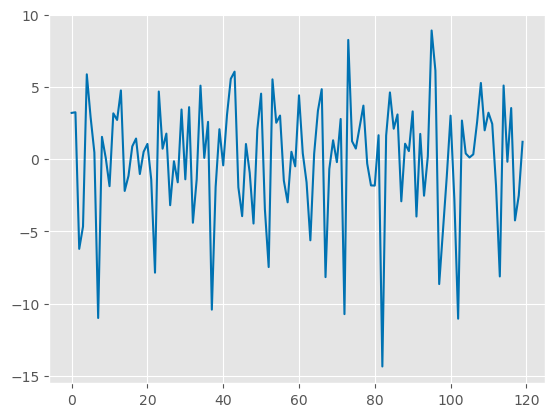

In [96]:
# create new dataframe with features and response variables
value = soy_yield['Value'].copy()
# match datetime index for properly joining value columns
value.index = clim_ind.index
df = clim_ind.copy()
df['Yield']  = value

# we don't need datetime index anymore, let's just move it to a column
df = df.reset_index()
df['Yield'].plot()

#### Splitting data to train and test
The rest of the parts require carefully separating train and validation data. Otherwise significant data leakage could occur. 

In [97]:
# Creat a function to split data for train and test and get dummies for states
def panel_data_split(df,y_column, test_size, one_hot_encoding=True):
    # Collect features and response columns from each state group in a list
    train_collect = []
    test_collect = []
    # loop over the soy_states and split train and test for each state
    for state in soy_states:
        # Select the state rows
        df_state = df.query('State == @state').copy()
        # split train and test for the state
        df_state_train = df_state[:-test_size]
        df_state_test = df_state[-test_size:]
        # append the train, test dataframe for the state in a list
        train_collect.append(df_state_train)
        test_collect.append(df_state_test)
    # concat the state train, test splits on axis=0
    df_train = pd.concat(train_collect, axis=0)
    df_test = pd.concat(test_collect, axis=0)
    # get dummies for states
    if one_hot_encoding == True:
        df_train = pd.get_dummies(df_train, prefix="", 
                                  prefix_sep="", drop_first=True)
        df_test = pd.get_dummies(df_test, prefix="", 
                                  prefix_sep="", drop_first=True)
    # Split the features and response columns
    X_train = df_train.drop(y_column, axis=1).reset_index(drop=True)
    y_train = df_train[y_column].reset_index(drop=True)
    X_test = df_test.drop(y_column, axis=1).reset_index(drop=True)
    y_test = df_test[y_column].reset_index(drop=True)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = panel_data_split(df, y_column='Yield',test_size=5, one_hot_encoding=False)
df_train_all = pd.concat([X_train, y_train], axis=1)
df_test_all = pd.concat([X_test, y_test], axis=1)

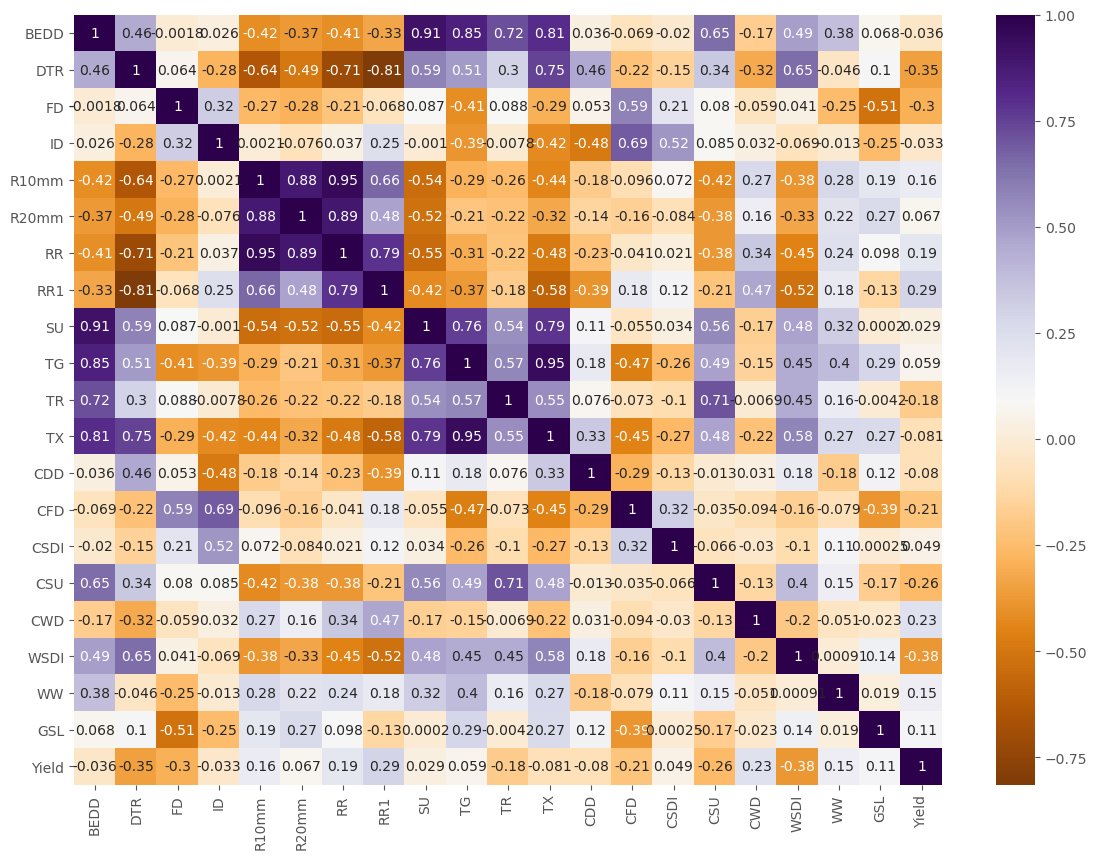

In [98]:
# let's plot pairwise correlation heatmap
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(df_train_all.corr(), annot=True, cmap='PuOr')
plt.show()

Let's recall what these variables
<a id='clim_ind_names'></a>

In [99]:
for var in agro_clim:
    long_name = agro_clim[var].long_name
    print(f'{var}: {long_name}')

BEDD: Biologically Effective Degree Days
DTR: Mean of diurnal temperature range
FD: Frost days (minimum temperature < 0 degrees_C)
ID: Ice days (maximum temperature < 0 degrees_C)
R10mm: Heavy precipitation days (precipitation >= 10 mm)
R20mm: Very heavy precipitation days (precipitation >= 20 mm)
RR: Precipitation sum
RR1: Wet days (precipitation >= 1 mm)
SU: Summer days (number of days where daily maximum temperature > 25 degrees_C)
TG: Mean of daily mean temperature
TR: Tropical nights (number of days where daily minimum temperature > 20 degrees_C)
TX: Mean of daily maximum temperature
CDD: Maximum number of consecutive dry days (precipitation < 1 mm)
CFD: Maximum number of consecutive frost days (minimum temperature < 0 degrees_C)
CSDI: Cold-spell duration index
CSU: Maximum number of consecutive summer days(temperature > 25 degrees_C)
CWD: Maximum number of consecutive wet days (precipitation >= 1 mm)
WSDI: Warm-spell duration index
WW: Warm and wet days
GSL: Growing season length

Let's drop some highly collinear variables, and some based on domain knowledge. For instance heavy and very heavy precipitation (R10mm & R20mm) could provide information on crop damage and run off loss. However, in this data it seems like both have a positive effect on crop yield. This is probably because of the annual aggregation ( actually growing season aggregation at each year) and spatial averaging over a large area which tends to mask the actual effect of the local events such as this. Furthermore, all the rain variables are strongly correlated to each other, this means when number of R20mm events is high at a certain year, RR1mm is very likely high too which is one of the key factor for higher yield. The other variables are dropped based on similar reasons, but will not be discussed here as it is beyond the scope of this study.

In [ ]:
vars_to_drop = ["BEDD", "DTR", "ID", "R10mm", "R20mm", "RR", "SU", "TR", "TX", "WW", "CSDI", "CFD"]
for var in df_train_all:
    if var in vars_to_drop:
        df_train = df_train_all.drop(var, axis=1)
        df_test = df_test_all.drop(var, axis=1)
df_train.head()

There are still some correlated variables such as TR and TG, with pearson r is 0.6, but I will keep them both because in general some increase in mean temperature is good for plants as it increases photosynthesis efficiency as long as maximum temperatures does not exceed a dengerous level. Therefore, keeping both TR and TG hopefully captures this relationship of temperature with yield.

In [102]:
# Let's see how strong the colinearity in overall data
np.linalg.det(df_train.corr())

1.5496985322499538e-12

The determinant of entire correlation matrix can be used as a proxy for how strong colinearity in the data. The closer the determinant to 1 is better (less colinearity). We have got a result indicating there is still some colinearity in the data. 

#### Checking Normality of the Variables.
Regression models assume that the variables are normally distributed. Therefore the following steps will be applied to check for distribution of the variables and transform those with high skeweness and kurtosis distributions:
* Do skewness test for each columns.
* Consider those with absolute value of skewness > 0.5 as skewed the rest as acceptable
* Apply box-cox transformation 

In [103]:
# Skewness test
skewed = df_train.drop('State', axis=1).skew().sort_values(ascending=False)
pd.DataFrame({'skewness': skewed})

,skewness
WSDI,2.363110
CSDI,2.132441
CDD,1.575828
DTR,1.069815
ID,0.682989
CWD,0.603883
GSL,0.340316
FD,0.332010
R20mm,0.330775
CSU,0.293348


Several variables are skewed. We can fix the skewness by applying power transformation to variables including the response variable. 

In [104]:
# Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_pt_train = pt.fit_transform(df_train.drop(['State', 'time'], axis=1))
df_pt_train = pd.DataFrame(df_pt_train, columns=
                         df_train.drop(['State', 'time'], axis=1).columns)
df_pt_train.index = df_train.index
df_pt_train['time'] = df_train['time']
df_pt_train['State'] = df_train['State']
pd.DataFrame(df_pt_train.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
FD,0.143554
GSL,0.142473
RR1,0.130090
RR,0.077204
R10mm,0.065207
DTR,0.048465
Yield,0.036550
R20mm,0.029385
CWD,0.007545
TX,0.000091


In [105]:
# Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
df_pt_test = pt.transform(df_test.drop(['State', 'time'], axis=1))
df_pt_test = pd.DataFrame(df_pt_test, columns=
                         df_test.drop(['State', 'time'], axis=1).columns)
df_pt_test.index = df_test.index
df_pt_test['time'] = df_test['time']
df_pt_test['State'] = df_test['State']
pd.DataFrame(df_pt_test.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
CSDI,1.188751
TG,0.614859
TX,0.329106
BEDD,0.320828
SU,0.249878
TR,0.241959
Yield,0.222808
WSDI,0.160802
RR1,0.108816
CFD,-0.034855


Some variables are a bit skewed in the test data, but notice that the size of the test data is rather small, only 20 sample. Even if the population was exactly normal, drawing 20 sample from this population would be likely to result slighlty skewed sample distribution. The same is true for the train data which has 100 samples, but this study about the methodology. The sample data can be extended in the future by calculating the agro-climatic indicators manually from fundemental climate variables which usually have larger sample size. Once a larger sample is obtained this notebook can be used as it is to built more reliable models.

In [106]:
X_train = df_pt_train.drop(['Yield','time'], axis=1)
X_train = pd.get_dummies(X_train, prefix="", 
                                  prefix_sep="", drop_first=True)
y_train = df_pt_train['Yield'] # keeping time for easy cross validation

X_test = df_pt_test.drop(['Yield','time'], axis=1)
X_test = pd.get_dummies(X_test, prefix="", 
                                  prefix_sep="", drop_first=True)
y_test = df_pt_test['Yield']

Now that all the variables are standardized and tranformed to normal distribution it is a good idea to revisit the colinearity check since pearson correlations are more reliable when the variables are normally distributed.

In [107]:
# Let's see how strong the colinearity in overall data
np.linalg.det(df_pt_train.drop('State', axis=1).corr())

1.0333320049317092e-11

The colinearity is reduced, but still not great. Some more variables could be droped, but I will leave that to Lasso regression. And PCA can handle colinearity. 

In [109]:
# sns.distplot(pd.Series(stats.boxcox(df['Yield']-df['Yield'].min()+0.1, lmbda=None)[0]), fit=norm)

In [ ]:
# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(np.log1p(df['WSDI']-df['WSDI'].min()+0.1), plot=plt)
# plt.show()

# Modelling
* The last 5 years of the data ( 4 states x 5 years = 20 data points) will be held for validation
* Cross validation requires special attention. Since this is a panel data cross validation would be more reliable if the validation data is selected based on the time index. 
    
<b style="color:red">High dimensionality problem:</b> <br>
We have 20 features 30 samples (each year) This is a problem because machine learning algorithms assumes P < n, (P: predictors, n: number of samples). Since the purpose of this study is to built an exploratry model rather than predictive model, the ultimate goal would be finding the most important features that effect crop yield. Also several parameters derived from each other. Strong colinearity surely exist among the features. The following approach may be applied to reduce the number of features and colinearity:

1. **Regularization:** Ridge, LASSO or Elastic Regressions with regularization paramaters. Would be helpful to find the most important factors affecting response variable.
2. **PCA:** PCA will help reduce the dimensions, and suitable when there is colinearity. However, we loose the interpretion ability of model. Can be used for prediction.


In [159]:
from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression
from sklearn.svm import LinearSVR, SVR

# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# RMSE
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#### Cross validation
For cross validation, the function `panel_data_split` that is defined above could be used. However, sklearn's TimeSeriesSplit function will be handy here.  

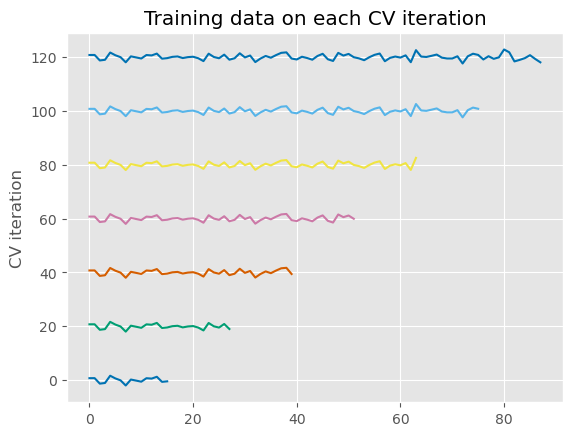

In [111]:
# For easy timesplitting let's add the time column 
# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=7)
# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(df_pt_train.sort_values('time'))):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii*20 + y_train[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()
plt.close()

In [16]:
def cv_score(model, df, n = 5):
    """Do cross validations for a panale data df.
    Retuns average rmse of n cross validation. 
    Note that dummy variables are created here."""
    
    # Create time-series cross-validation object
    cv = TimeSeriesSplit(n_splits=n)
    # Iterate through CV splits
    hold_score = []
    for train_index,test_index in cv.split(df):
        # split based on year 
        df_sorted = df.sort_values('time')\
            .reset_index(drop=True)
        train = df_sorted.loc[train_index]\
            .sort_values(['State', 'time']).reset_index(drop=True)
        Xtrain = train.drop(['Yield', 'time'], axis=1)
        Xtrain = pd.get_dummies(Xtrain, drop_first=True)
        ytrain = train['Yield']

        # repeating for validation data
        test = df_sorted.loc[test_index]\
            .sort_values(['State', 'time']).reset_index(drop=True)
        Xtest = test.drop(['Yield', 'time'], axis=1)
        Xtest = pd.get_dummies(Xtest, drop_first=True)
        ytest = test['Yield']
        # Fitting the model
        model.fit(Xtrain, ytrain)
        # predict for validation set 
        ypred = model.predict(Xtest)
        hold_score.append(rmse(ytest, ypred))
    return np.mean(hold_score)

In [79]:
model_eval = {'model':[], 'rmse_train':[], 'rmse_test':[]}
def param_search_alpha(df, model, alphas, title, cv=5):
    scores = {'alpha':[], 'rmse':[]}
    for alpha in alphas:
        mdl = model(alpha=alpha, max_iter=5000)
        rmse_cv= cv_score(mdl, df, n=cv)
        scores['alpha'].append(alpha)
        scores['rmse'].append(rmse_cv)
    df_scores = pd.DataFrame(scores).sort_values('rmse').reset_index(drop=True)
    min_pos = df_scores['rmse'].idxmin(axis=1)
    df_scores.plot.scatter(x='alpha', y='rmse')
    plt.title(title)
    plt.show()
    best_alpha = df_scores.loc[min_pos]['alpha']
    print('the best alpha')
    print(best_alpha)
    
    # Let's use the best alpha and fit to entire training data
    mdl = model(alpha=best_alpha, max_iter=10000)
    mdl.fit(X_train, y_train)
    # calculate rmse for the training set
    y_pred = mdl.predict(X_train)
    train_rmse = rmse(y_train, y_pred)
    # Let's predict the test data and calculate rmse
    y_pred = mdl.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    print(f'rmse for train data: {train_rmse}')
    print(f'rmse for test data: {test_rmse}')
    
    return mdl, train_rmse, test_rmse

#### Lasso Regression

In [191]:
X_train.columns

Index(['BEDD', 'DTR', 'FD', 'ID', 'R10mm', 'R20mm', 'RR', 'RR1', 'SU', 'TG',
       'TR', 'TX', 'CDD', 'CFD', 'CSDI', 'CSU', 'CWD', 'WSDI', 'GSL',
       'INDIANA', 'IOWA', 'NORTH DAKOTA'],
      dtype='object')

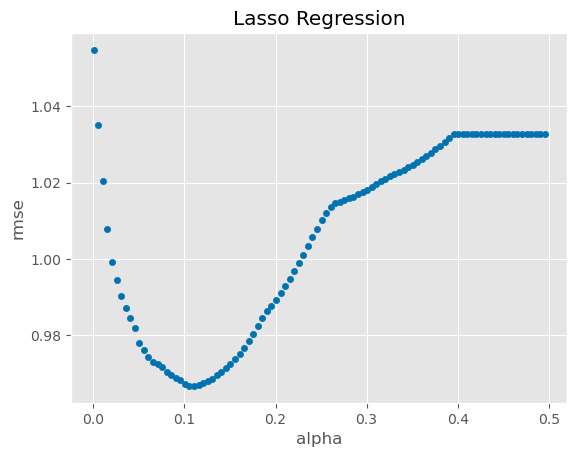

the best alpha
0.10549999999999998
rmse for train data: 0.8374863301948597
rmse for test data: 0.6463708075661868


Lasso(alpha=0.1055)

In [192]:
lasso_reg, train_rmse, test_rmse = param_search_alpha(df_pt_train[['SU','CFD', 'RR1', 'CWD','WSDI','time','State','Yield']], Lasso, alphas=np.arange(0.0005, 0.5, 0.005), 
                 title='Lasso Regression', cv=3)
model_eval['model'].append('Lasso')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)
lasso_reg = Lasso(alpha=0.1055)
lasso_reg.fit(X_train[['SU','CFD', 'RR1', 'CWD','WSDI']], y_train)


In [197]:
y_pred = lasso_reg.predict(X_train[['SU','CFD', 'RR1', 'CWD','WSDI']])
print(rmse(y_train, y_pred))
lasso_reg.score(X_test[['SU','CFD', 'RR1', 'CWD','WSDI']], y_test)

0.8890065803954236


-0.11333245482798882

#### Ridge Regression

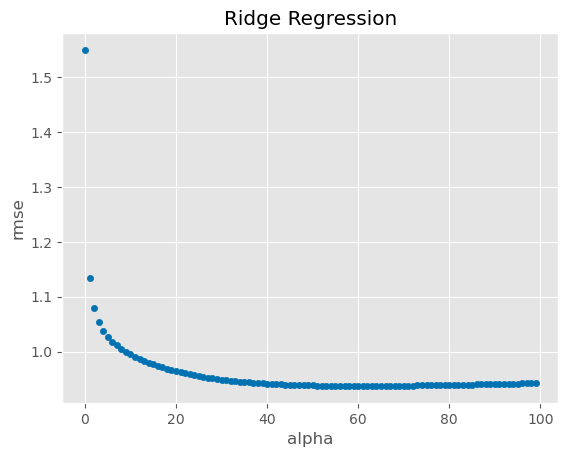

the best alpha
61.01
rmse for train data: 0.7998337530388422
rmse for test data: 0.7153626732450349


In [115]:
ridge_reg, train_rmse, test_rmse = param_search_alpha(df_pt_train, Ridge, np.arange(0.01, 100, 1), cv=3,
                 title='Ridge Regression')
model_eval['model'].append('Ridge')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)

#### ElasticNet Regression

In [140]:
def param_search_alpha_l1(df, alphas, l1ratio, cv=5):
    """Grid Search parametrization for ElasticNet Regression"""
    scores = {'alpha':[], 'l1_ratio':[], 'rmse':[]}
    for alpha in alphas:
        for l1 in l1ratio:
            mdl = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=5000)
            rmse_cv= cv_score(mdl, df, n=cv)
            scores['alpha'].append(alpha)
            scores['l1_ratio'].append(l1)
            scores['rmse'].append(rmse_cv)
    df_scores = pd.DataFrame(scores).sort_values('rmse').reset_index(drop=True)
    min_pos = df_scores['rmse'].idxmin(axis=1)
    best_alpha = df_scores.loc[min_pos]['alpha']
    best_l1 = df_scores.loc[min_pos]['l1_ratio']
    print(f'the best alpha: {best_alpha}')
    print(f'Optimum l1_ratio: {best_l1}')
    
    # Let's use the best alpha and l1_ratio to fit the entire training data
    mdl = ElasticNet(alpha=best_alpha, l1_ratio=best_l1)
    mdl.fit(X_train, y_train)
    # calculate rmse for the training set
    y_pred = mdl.predict(X_train)
    train_rmse = rmse(y_train, y_pred)
    # Let's predict the test data and calculate rmse
    y_pred = mdl.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    print(f'rmse for train data: {train_rmse}')
    print(f'rmse for test data: {test_rmse}')
    
    train_score = mdl.score(X_train,y_train)
    test_score = mdl.score(X_test, y_test)
    print(f'R^2 for train: {train_score}')
    print(f'R^2 for test: {test_score}')
    
    return mdl,df_scores, train_rmse, test_rmse

In [141]:
elastic_reg,df_scores, train_rmse, test_rmse = param_search_alpha_l1(df_pt_train, 
                                                                     np.arange(1, 2, 0.1), 
                                                                     [1.8e-15, 2e-15,1.9e-15], cv=3)

the best alpha: 1.2000000000000002
Optimum l1_ratio: 1.8e-15
rmse for train data: 0.8390861562823908
rmse for test data: 0.6568442189554663
R^2 for train: 0.2959344223352435
R^2 for test: -0.3639330884022085


In [173]:
elastic_reg = ElasticNet(alpha=2, l1_ratio=0.0721)
elastic_reg.fit(X_train, y_train)
# calculate rmse for the training set
y_pred = elastic_reg.predict(X_train)
train_rmse = rmse(y_train, y_pred)
# Let's predict the test data and calculate rmse
y_pred = elastic_reg.predict(X_test)
test_rmse = rmse(y_test, y_pred)
# model_eval['model'].append('ElasticNet')
# model_eval['rmse_train'].append(train_rmse)
# model_eval['rmse_test'].append(test_rmse)
print(f'rmse for train data: {train_rmse}')
print(f'rmse for test data: {test_rmse}')

train_score = elastic_reg.score(X_train,y_train)
test_score = elastic_reg.score(X_test, y_test)
print(f'R^2 for train: {train_score}')
print(f'R^2 for test: {test_score}')

rmse for train data: 0.9366272644165915
rmse for test data: 0.5741343865069816
R^2 for train: 0.12272936755149266
R^2 for test: -0.042066462484879


### SVM

In [180]:
def param_search_crange(df, crange, cv=5):
    """Grid Search parametrization for SVM Regression"""
    scores = {'C':[], 'rmse':[]}
    for c in crange:
        mdl = LinearSVR(C=c, max_iter=5000)
        rmse_cv= cv_score(mdl, df, n=cv)
        scores['C'].append(c)
        scores['rmse'].append(rmse_cv)
    df_scores = pd.DataFrame(scores).sort_values('rmse').reset_index(drop=True)
    min_pos = df_scores['rmse'].idxmin(axis=1)
    best_c = df_scores.loc[min_pos]['C']
    print(f'optimal C: {best_c}')
    
    # Let's use the best alpha and l1_ratio to fit the entire training data
    mdl = LinearSVR(C=best_c)
    mdl.fit(X_train, y_train)
    # calculate rmse for the training set
    y_pred = mdl.predict(X_train)
    train_rmse = rmse(y_train, y_pred)
    # Let's predict the test data and calculate rmse
    y_pred = mdl.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    print(f'rmse for train data: {train_rmse}')
    print(f'rmse for test data: {test_rmse}')
    
    return mdl,df_scores, train_rmse, test_rmse

In [181]:
SVR_reg,df_scores_svm, train_rmse, test_rmse = param_search_crange(df_pt_train, np.arange(0.001,1.0,0.01), cv=3)
model_eval['model'].append('SVM')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)

optimal C: 0.020999999999999998
rmse for train data: 0.8040797612294915
rmse for test data: 0.8100996876829819


In [ ]:
evaluation_model = pd.DataFrame(model_eval)
evaluation_model.sort_values('rmse_test')

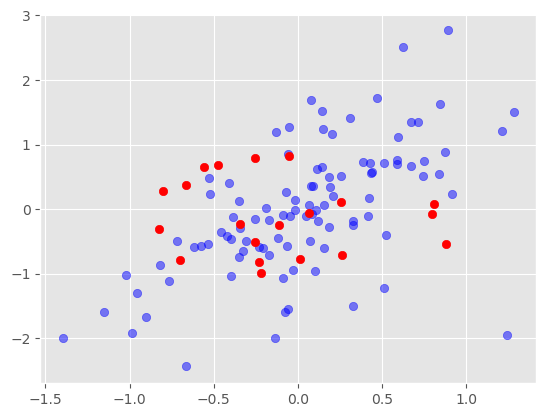

In [184]:
y_pred = SVR_reg.predict(X_train)
plt.scatter(y_pred, y_train, c='b', alpha=0.5)
y_pred = SVR_reg.predict(X_test)
plt.scatter(y_pred, y_test, c='r')

In [ ]:
y_pred = lasso_reg.predict(X_train)
plt.scatter(y_pred, y_train, c='b', alpha=0.5)
y_pred = lasso_reg.predict(X_test)
plt.scatter(y_pred, y_test, c='r')

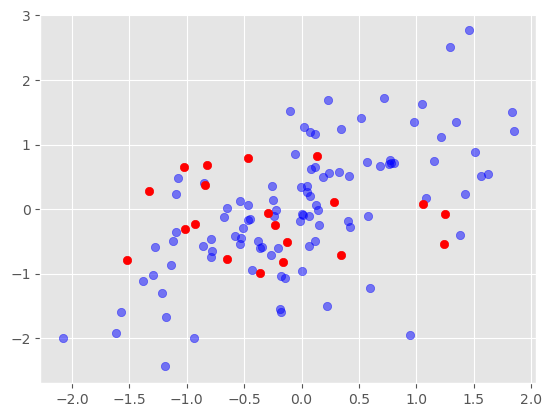

In [178]:
y_pred = ridge_reg.predict(X_train)
plt.scatter(2*y_pred, y_train, c='b', alpha=0.5)
y_pred = ridge_reg.predict(X_test)
plt.scatter(2*y_pred, y_test, c='r')

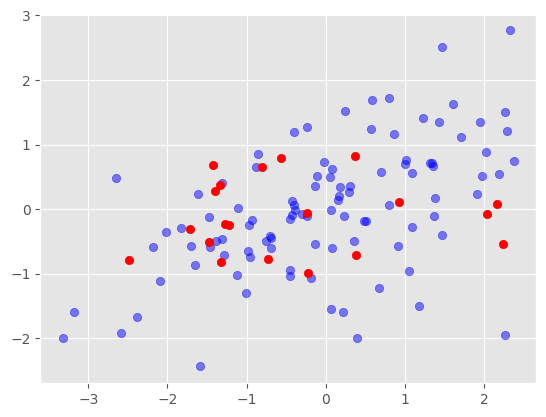

In [176]:
y_pred = elastic_reg.predict(X_train)
plt.scatter(10*y_pred, y_train, c='b', alpha=0.5)
y_pred = elastic_reg.predict(X_test)
plt.scatter(10*y_pred, y_test, c='r')

In [1365]:
# Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_pt_train_all = pt.fit_transform(df_train_all.drop(['State', 'time'], axis=1))
df_pt_train_all = pd.DataFrame(df_pt_train_all, columns=
                         df_train_all.drop(['State', 'time'], axis=1).columns)
df_pt_train_all.index = df_train_all.index
df_pt_train_all['time'] = df_train_all['time']
df_pt_train_all['State'] = df_train_all['State']
pd.DataFrame(df_pt_train_all.skew().sort_values(ascending=False), columns=['skewness'])
# Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
df_pt_test_all = pt.fit_transform(df_test_all.drop(['State', 'time'], axis=1))
df_pt_test_all = pd.DataFrame(df_pt_test_all, columns=
                         df_test_all.drop(['State', 'time'], axis=1).columns)
df_pt_test_all.index = df_test_all.index
df_pt_test_all['time'] = df_test_all['time']
df_pt_test_all['State'] = df_test_all['State']
pd.DataFrame(df_pt_test_all.skew().sort_values(ascending=False), columns=['skewness']).T

,CDD,TG,WSDI,TR,CFD,WW,R10mm,TX,CSU,CWD,...,DTR,RR1,Yield,GSL,R20mm,FD,BEDD,ID,CSDI,RR
skewness,0.219801,0.194465,0.160864,0.129763,0.114123,0.09299,0.060436,0.058868,0.016875,0.015023,...,-0.001254,-0.008477,-0.016729,-0.034245,-0.039963,-0.041471,-0.067185,-0.069234,-0.130051,-0.184212


In [1466]:
X_train_all = df_pt_train_all.drop(['Yield','time'], axis=1)
X_train_all = pd.get_dummies(X_train_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_train_all = df_pt_train_all['Yield'] # keeping time for easy cross validation

X_test_all = df_pt_test_all.drop(['Yield','time'], axis=1)
X_test_all = pd.get_dummies(X_test_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_test_all = df_pt_test_all['Yield']

In [1371]:
X_train_all = df_train_all.drop(['Yield','time'], axis=1)
X_train_all = pd.get_dummies(X_train_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_train_all = df_train_all['Yield'] # keeping time for easy cross validation

X_test_all = df_test_all.drop(['Yield','time'], axis=1)
X_test_all = pd.get_dummies(X_test_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_test_all = df_test_all['Yield']

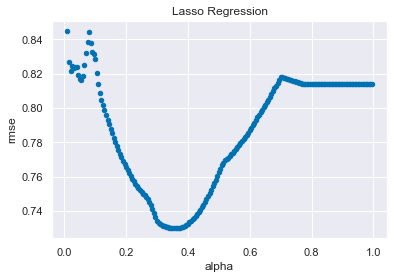

the best alpha
0.35999999999999993


TypeError: The DTypes <class 'numpy.dtype[float64]'> and <class 'numpy.dtype[datetime64]'> do not have a common DType. For example they cannot be stored in a single array unless the dtype is `object`.

In [1350]:
param_search_alpha(df_pt_train_all[:25], Lasso, alphas=np.arange(0.01,1, 0.005), 
                 title='Lasso Regression', cv=3)

In [1353]:
# Let's use the best alpha and fit to entire training data
mdl = Lasso(alpha=0.36)
mdl.fit(X_train_all[:25], y_train_all[:25])
# calculate rmse for the training set
y_pred = mdl.predict(X_train_all[:25])
train_rmse = rmse(y_train_all[:25], y_pred[:25])
# Let's predict the test data and calculate rmse
y_pred = mdl.predict(X_test_all[:25])
test_rmse = rmse(y_test_all[:25], y_pred[:25])
print(f'rmse for train data: {train_rmse}')
print(f'rmse for test data: {test_rmse}')

rmse for train data: 0.7790932905433221
rmse for test data: 1.02719510347205


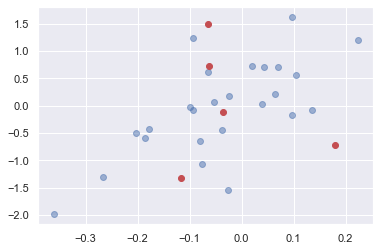

In [1356]:
y_pred = mdl.predict(X_train_all[:25])
plt.scatter(y_pred, y_train_all[:25], c='b', alpha=0.5)
y_pred = mdl.predict(X_test_all[:5])
plt.scatter(y_pred, y_test_all[:5], c='r')

In [1357]:
mdl.score(X_test_all, y_test_all)

-0.0551297805969555

In [1358]:
mdl.score(X_train_all, y_train_all)

0.07043902282639902

In [1321]:
# Let's use the best alpha and fit to entire training data
mdl = Ridge(alpha=2900)
mdl.fit(X_train_all, y_train_all)
# calculate rmse for the training set
y_pred = mdl.predict(X_train_all)
train_rmse = rmse(y_train_all, y_pred)
# Let's predict the test data and calculate rmse
y_pred = mdl.predict(X_test_all)
test_rmse = rmse(y_test_all, y_pred)
print(f'rmse for train data: {train_rmse}')
print(f'rmse for test data: {test_rmse}')

rmse for train data: 3.711916718228485
rmse for test data: 2.948886079233587


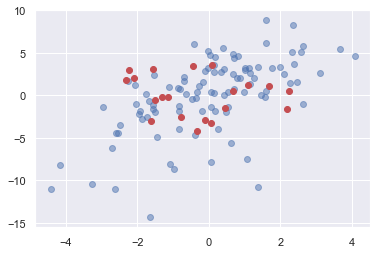

In [1324]:
y_pred_train = mdl.predict(X_train_all)
plt.scatter(y_pred_train, y_train_all, c='b', alpha=0.5)
y_pred_test = mdl.predict(X_test_all)
plt.scatter(y_pred_test, y_test_all, c='r')

In [1327]:
mdl.score(X_test_all, y_test_all)

-0.5701639727217869

In [1372]:
from sklearn.linear_model import LinearRegression
# Let's use the best alpha and fit to entire training data
mdl = LinearRegression()
mdl.fit(X_train_all, y_train_all)
# calculate rmse for the training set
y_pred = mdl.predict(X_train_all)
train_rmse = rmse(y_train_all, y_pred)
# Let's predict the test data and calculate rmse
y_pred = mdl.predict(X_test_all)
test_rmse = rmse(y_test_all, y_pred)
print(f'rmse for train data: {train_rmse}')
print(f'rmse for test data: {test_rmse}')

rmse for train data: 2.9769766567886684
rmse for test data: 3.3683526572035087


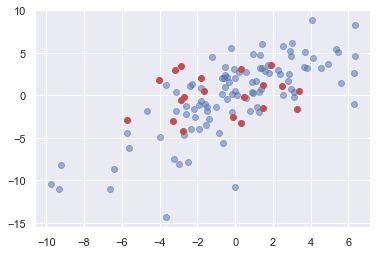

In [1373]:
y_pred_train = mdl.predict(X_train_all)
plt.scatter(y_pred_train, y_train_all, c='b', alpha=0.5)
y_pred_test = mdl.predict(X_test_all)
plt.scatter(y_pred_test, y_test_all, c='r')

In [1374]:
mdl.score(X_train_all, y_train_all)

0.5527005832446948

In [1375]:
mdl.score(X_test_all, y_test_all)

-1.0486328244340761

rmse for train data: 0.8404164458982056
rmse for test data: 0.7862893543244759


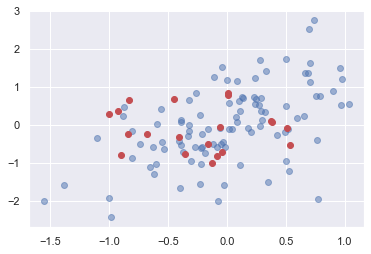

In [1377]:
from sklearn.linear_model import LinearRegression
# Let's use the best alpha and fit to entire training data
mdl = LinearRegression()
mdl.fit(X_train, y_train)
# calculate rmse for the training set
y_pred = mdl.predict(X_train)
train_rmse = rmse(y_train, y_pred)
# Let's predict the test data and calculate rmse
y_pred = mdl.predict(X_test)
test_rmse = rmse(y_test, y_pred)
print(f'rmse for train data: {train_rmse}')
print(f'rmse for test data: {test_rmse}')
y_pred_train = mdl.predict(X_train)
plt.scatter(y_pred_train, y_train, c='b', alpha=0.5)
y_pred_test = mdl.predict(X_test)
plt.scatter(y_pred_test, y_test, c='r')

In [1378]:
mdl.score(X_train, y_train)

0.2937001974638286

In [1379]:
mdl.score(X_test, y_test)

-0.9544883805940689

#### Regular Cross Validation
<a id='reg_cv'></a>

In [83]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV

In [1491]:
Xtrain = df.drop(['Yield', 'time','State'], axis=1)[:-20]
# Xtrain = pd.get_dummies(Xtrain, drop_first=True)
Xtest = df.drop(['Yield', 'time', 'State'], axis=1)[-20:]
# Xtest = pd.get_dummies(Xtest, drop_first=True)
ytrain = df['Yield'][:-20].reset_index(drop=True)
ytest = df['Yield'][-20:].reset_index(drop=True)

In [84]:
def rmse_cv(Xtrain,ytrain,model,k):
    rmse= np.sqrt(-cross_val_score(model, Xtrain, ytrain, scoring="neg_mean_squared_error", cv = k))
    return(rmse)

In [1493]:
model_ridge = Ridge()

In [1494]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100, 200, 300, 500]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

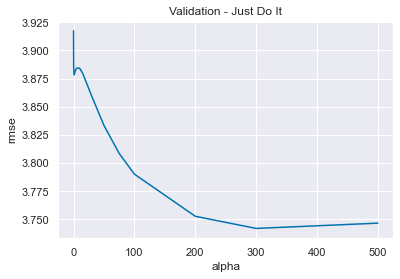

In [1433]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [1434]:
cv_ridge.min()

3.7420596280838767

In [1467]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=10000).fit(X_train_all, y_train_all)

In [1468]:
rmse_cv(model_lasso).mean()

3.8794303657871074

In [1470]:
coef = pd.Series(model_lasso.coef_, index = X_train_all.columns)

In [1471]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 8 variables and eliminated the other 15 variables


In [1472]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

In [1474]:
model_lasso.score(X_train_all, y_train_all)

0.3114543809160599

In [1473]:
model_lasso.score(X_test_all, y_test_all)

-0.13404433718148412

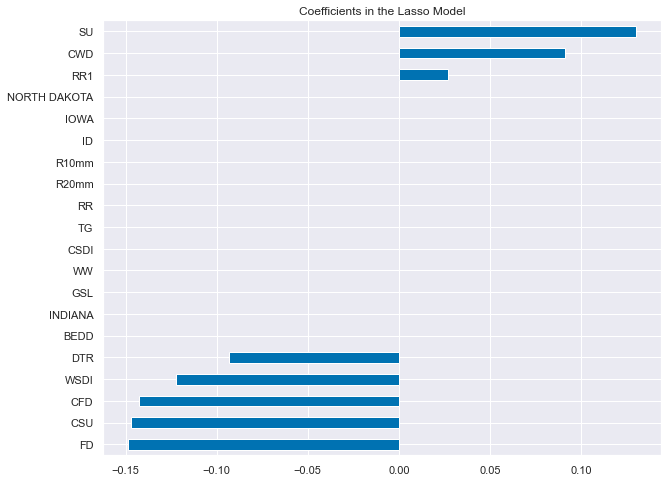

In [1475]:
imp_coef.plot(kind = "barh", figsize=(10,8))
plt.title("Coefficients in the Lasso Model")
plt.show()

<AxesSubplot:xlabel='preds', ylabel='residuals'>

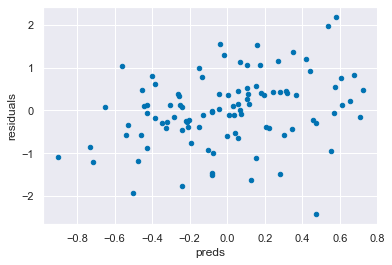

In [1476]:
preds = pd.DataFrame({"preds":model_lasso.predict(X_train_all), "true":y_train_all})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [126]:
import xgboost as xgb

In [1486]:
dtrain = xgb.DMatrix(X_train_all, label = y_train_all)
dtest = xgb.DMatrix(X_test_all)

# params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot:>

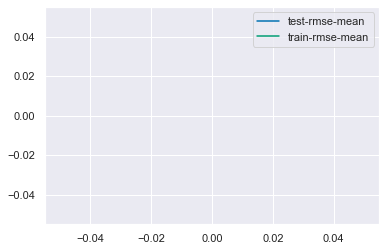

In [1487]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [1496]:
model_xgb = xgb.XGBRegressor(max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [1498]:
model_xgb.score(Xtest,ytest)

0.5605330094206433

In [1447]:
xgb_preds = (model_xgb.predict(Xtest))
lasso_preds = model_lasso.predict(Xtest)

<AxesSubplot:xlabel='xgb', ylabel='lasso'>

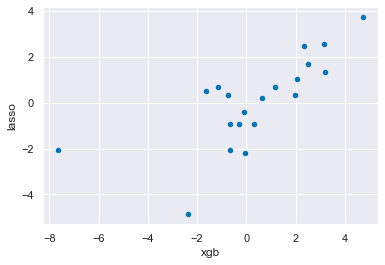

In [1448]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [1450]:
X_train_all = df_train_all.drop(['Yield','time'], axis=1)
X_train_all = pd.get_dummies(X_train_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_train_all = df_train_all['Yield'] # keeping time for easy cross validation

X_test_all = df_test_all.drop(['Yield','time'], axis=1)
X_test_all = pd.get_dummies(X_test_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_test_all = df_test_all['Yield']

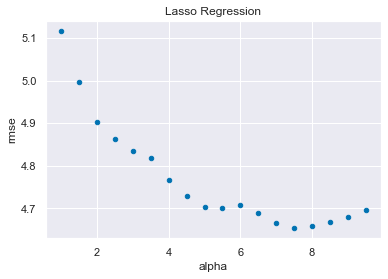

the best alpha
7.5
rmse for train data: 1.0
rmse for test data: 0.5734298137563436


(Lasso(alpha=7.5, max_iter=10000), 1.0, 0.5734298137563436)

In [1453]:
param_search_alpha(df_train_all, Lasso, alphas=np.arange(1,10, 0.5), 
                 title='Lasso Regression', cv=3)

In [1454]:
# Let's use the best alpha and fit to entire training data
mdl = Lasso(alpha=7.5)
mdl.fit(X_train_all, y_train_all)
# calculate rmse for the training set
y_pred = mdl.predict(X_train_all)
train_rmse = rmse(y_train_all, y_pred)
# Let's predict the test data and calculate rmse
y_pred = mdl.predict(X_test_all)
test_rmse = rmse(y_test_all, y_pred)
print(f'rmse for train data: {train_rmse}')
print(f'rmse for test data: {test_rmse}')

rmse for train data: 4.255475732141552
rmse for test data: 2.4066324375330796


* Transformed all data r2 train 0.53 r2 test -0.78
* Raw all data r2 train 0.55 r2 test -1
* Transformed selected r2 train 0.29  test -0.95

# County Level Models
Despite all the good intentions and efforts, state-level regression models were not succesful, even worse than simple time series analysis (see below ARIMA section below). It's actually a no surprise considering how small the sample size is. Large spatial averaging makes it even worse, hence the results. To improve this without obtaining a larger sample size, we can try builing a county level model. 

In this section I will select a single county (Arkansas County) which is one the top in the U.S. for soybeans production. 

In [4]:
# Read the shape file for US Counties using Geopandas package
path_geo = 'C:\\Users\\kurt_\\Data\\tl_2020_us_county\\'
counties_bound = geopandas.read_file(path_geo)
print('The coordinate Reference System Info:')
print(counties_bound.crs)

# Select the Arkansas county
counties_bound[counties_bound.NAME == 'Arkansas']

The coordinate Reference System Info:
epsg:4269


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
300,05,001,00063755,05001,Arkansas,Arkansas County,06,H1,G4020,None,None,None,A,2569632248,120698180,+34.2895697,-091.3765466,"POLYGON ((-91.59593 34.48051, -91.59558 34.480..."


SOYBEANS states: ['Arkansas']


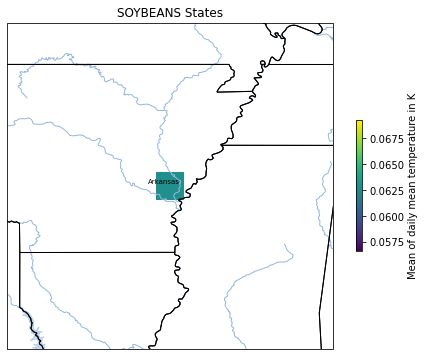

In [22]:
# Now let's select the climate indicitors for Arkansas
coord_file = 'C:\\Users\\kurt_\\Data\\tl_2020_us_county\\tl_2020_us_county.shp'
county_clim = sel_states(agro_clim,
                            crop='SOYBEANS', var='TG', file_path=coord_file, states='Arkansas', _plot=True)
# Notice that I used the sel_state function to select the Arkansas county, not the whole state

In [23]:
# Calculate correct spatial mean for the county
county_clim = grid_mean(county_clim) # only dimension is time now

# convert the county_clim to a dataframe
county_clim = county_clim.to_dataframe()
county_clim.head(3)

,BEDD,DTR,FD,ID,R10mm,R20mm,RR,RR1,SU,TG,TR,TX,CDD,CFD,CSDI,CSU,CWD,WSDI,WW,GSL
time,,,,,,,,,,,,,,,,,,,,
1981-01-01,-79.212814,-0.320337,-1.677419,0.0,5.122581,-2.905377,13.438366,-3.019354,-10.187097,-0.212136,0.619355,-0.288478,-1.010754,-0.251613,-1.488172,0.907527,-2.255914,1.191398,-2.926881,-28.137634
1982-01-01,-54.551632,-0.087509,3.396885,0.0,-1.837598,2.145569,-38.365513,8.616465,-4.153503,-0.302943,-0.844049,-0.339879,-1.322656,1.765740,-1.463701,1.336893,-0.116425,0.994290,2.155432,16.232777
1983-01-01,41.591484,0.185270,-1.528810,0.0,-3.797776,1.196514,-27.051657,-8.747719,0.880089,0.227405,2.692547,0.222398,6.365442,-1.216908,-1.439229,1.766259,-4.976937,0.797182,-1.762254,-5.396810


Let's read the soybeans yield data for Arkansas county. This dataset already preprocessed mostly. Therefore, the majority of the data wrangling process can be skipped. [Ref. Cell](#PrepareYieldModelling)

In [46]:
# read soybeans yield data for Arkansas county
df_soyAK =pd.read_csv('Data\\soybeansAK.csv')
df_soyAK = df_soyAK.sort_values('Year')

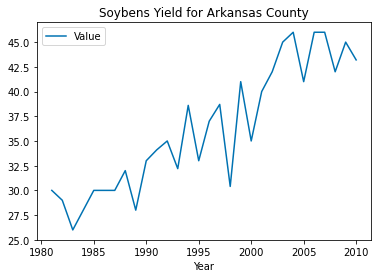

In [50]:
# Select years matching county_clim 
year_first = county_clim.index[0].year
year_last = county_clim.index[-1].year
df_soyAK = df_soyAK[(df_soyAK.Year >= year_first) & 
                      (df_soyAK.Year <= year_last)]
# plot Yield Values by year to see the trend
df_soyAK.plot(x='Year',y='Value')
plt.title('Soybens Yield for Arkansas County')
plt.show()

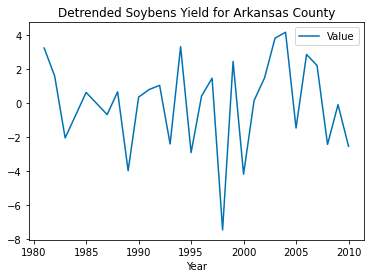

In [51]:
# detrending the yield data
df_soyAK.loc[:,'Value'] = detrend(df_soyAK['Value']).values
df_soyAK.plot(x='Year',y='Value')
plt.title('Detrended Soybens Yield for Arkansas County')
plt.show()

In [55]:
# create new dataframe with features and response variables
value = df_soyAK['Value'].copy()
# match datetime index for properly joining value columns
value.index = county_clim.index
df = county_clim.copy()
df['Yield']  = value

# we don't need datetime index anymore, let's just move it to a column
df = df.reset_index()
df.head(3)

,time,BEDD,DTR,FD,ID,R10mm,R20mm,RR,RR1,SU,...,TX,CDD,CFD,CSDI,CSU,CWD,WSDI,WW,GSL,Yield
0,1981-01-01,-79.212814,-0.320337,-1.677419,0.0,5.122581,-2.905377,13.438366,-3.019354,-10.187097,...,-0.288478,-1.010754,-0.251613,-1.488172,0.907527,-2.255914,1.191398,-2.926881,-28.137634,3.260645
1,1982-01-01,-54.551632,-0.087509,3.396885,0.0,-1.837598,2.145569,-38.365513,8.616465,-4.153503,...,-0.339879,-1.322656,1.765740,-1.463701,1.336893,-0.116425,0.994290,2.155432,16.232777,1.605428
2,1983-01-01,41.591484,0.185270,-1.528810,0.0,-3.797776,1.196514,-27.051657,-8.747719,0.880089,...,0.222398,6.365442,-1.216908,-1.439229,1.766259,-4.976937,0.797182,-1.762254,-5.396810,-2.049789


In [58]:
# Drop Ice Days (ID) column, which is all 0. Max temp < 0 never happened here.
df.drop('ID', axis=1,inplace=True)

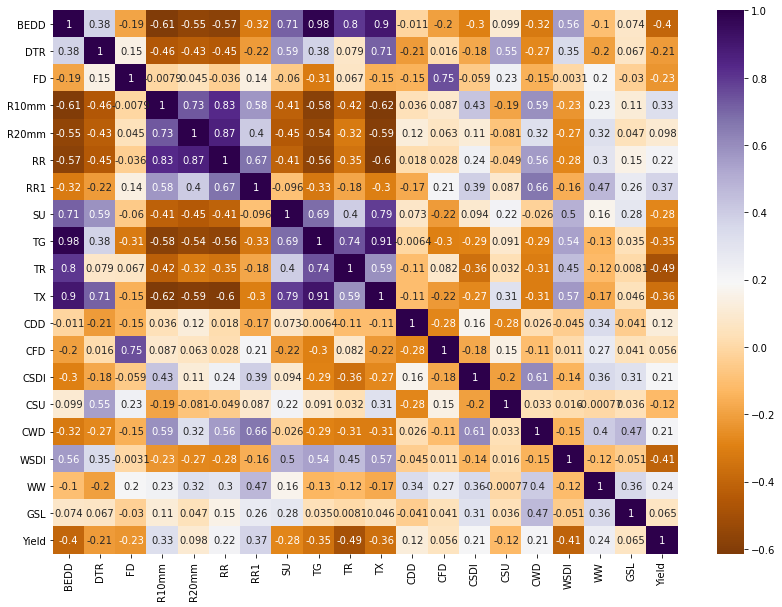

In [59]:
# let's plot pairwise correlation heatmap
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='PuOr')
plt.show()

See [here for reference to variable names](#clim_ind_names)

In [72]:
# Drop Highly colinear features and more based on expert judgement
vars_to_drop = ['BEDD', 'CFD', 'R10mm', 'R20mm', 'RR', 'SU', 'TG', 'TX','WSDI','WW','GSL', 'CSDI']
df_select = df.drop(vars_to_drop, axis=1)

In [73]:
# Split the data to train and test
train_select = df_select[:-5]
test_select = df_select[-5:]

In [74]:
# Let's see how strong the colinearity in overall data
np.linalg.det(train_select.corr())

0.08279230799731296

In [75]:
# Skewness test
skewed = train_select.skew().sort_values(ascending=False)
pd.DataFrame({'skewness': skewed})

,skewness
CDD,1.670750
CWD,1.020883
FD,0.851561
TR,0.499665
DTR,0.005308
RR1,-0.332776
Yield,-0.817292
CSU,-1.724401


Some variables are highyly skewed. Let's do power transformation to entire data

In [76]:
# Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
pt = PowerTransformer(method='yeo-johnson', standardize=True)
train_select_pt = pt.fit_transform(train_select.drop(['time'], axis=1))
train_select_pt = pd.DataFrame(train_select_pt, columns=
                         train_select.drop(['time'], axis=1).columns)
train_select_pt.index = train_select.index
train_select_pt['time'] = train_select['time']
pd.DataFrame(train_select_pt.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
TR,0.360535
CWD,0.134859
FD,0.050481
CSU,0.031776
Yield,0.002952
DTR,-0.007709
RR1,-0.037538
CDD,-0.271959


In [77]:
# Apply same transformation to test data
test_select_pt = pt.transform(test_select.drop(['time'], axis=1))
test_select_pt = pd.DataFrame(test_select_pt, columns=
                         test_select.drop(['time'], axis=1).columns)
test_select_pt.index = test_select.index
test_select_pt['time'] = test_select['time']
pd.DataFrame(test_select_pt.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
TR,0.723409
CDD,0.712438
Yield,0.294677
CWD,0.081344
CSU,0.026682
RR1,-0.320932
DTR,-0.443870
FD,-0.541025


In [85]:
X_train = train_select_pt.drop(['Yield','time'], axis=1)
X_train = pd.get_dummies(X_train, prefix="", 
                                  prefix_sep="", drop_first=True)
y_train = train_select_pt['Yield'] # keeping time for easy cross validation

X_test = test_select_pt.drop(['Yield','time'], axis=1)
X_test = pd.get_dummies(X_test, prefix="", 
                                  prefix_sep="", drop_first=True)
y_test = test_select_pt['Yield']

In [143]:
# Let's collect the train test split and power transformation steps in a function
def split_transform(df, test_size):
    # Split the data to train and test
    train = df[:-test_size]
    test = df[-test_size:]
    # Apply yeo-johnson power transformation whcih is unlike box-cox method allows negative values
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    train_pt = pt.fit_transform(train.drop(['time'], axis=1))
    train_pt = pd.DataFrame(train_pt, columns=
                             train.drop(['time'], axis=1).columns)
    train_pt.index = train.index
    train_pt['time'] = train['time']
    pd.DataFrame(train_pt.skew().sort_values(ascending=False), columns=['skewness'])
    
    # Apply same transformation to test data
    test_pt = pt.transform(test.drop(['time'], axis=1))
    test_pt = pd.DataFrame(test_pt, columns=
                             test.drop(['time'], axis=1).columns)
    test_pt.index = test.index
    test_pt['time'] = test['time']
    pd.DataFrame(test_pt.skew().sort_values(ascending=False), columns=['skewness'])
    
    X_train = train_pt.drop(['Yield','time'], axis=1)
    X_train = pd.get_dummies(X_train, prefix="", 
                                      prefix_sep="", drop_first=True)
    y_train = train_pt['Yield'] # keeping time for easy cross validation

    X_test = test_pt.drop(['Yield','time'], axis=1)
    X_test = pd.get_dummies(X_test, prefix="", 
                                      prefix_sep="", drop_first=True)
    y_test = test_pt['Yield']
    
    return X_train, X_test, y_train, y_test

In [137]:
def rmse_cv(Xtrain,ytrain,model,k):
    rmse= np.sqrt(-cross_val_score(model, Xtrain, ytrain, scoring="neg_mean_squared_error", cv = k))
    return(rmse)

[Ref. Cell](#reg_cv)
### Ridge Regression

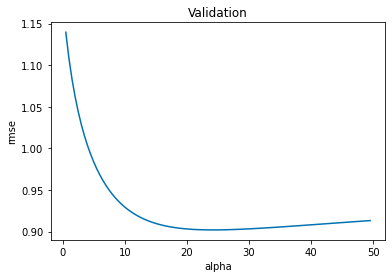

Optimum alpha = 24.0


In [104]:
alphas = np.arange(0.5,50,0.5)
cv_ridge = [rmse_cv(X_train, y_train,Ridge(alpha = alpha),k=3).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()
best_alpha = cv_ridge.idxmin()
print(f'Optimum alpha = {best_alpha}')

In [108]:
mdl_ridge = Ridge(alpha=24)
mdl_ridge.fit(X_train, y_train)
mdl_ridge.score(X_test, y_test)

-0.21289925707080082

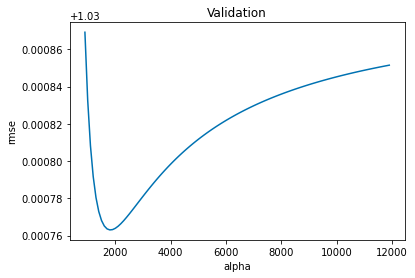

Optimum alpha = 1800


In [149]:
# ridge regression with all the columns
X_train, X_test, y_train, y_test = split_transform(df, 10)
alphas = np.arange(900,12000,100)
cv_ridge = [rmse_cv(X_train, y_train,Ridge(alpha = alpha),k=3).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()
best_alpha = cv_ridge.idxmin()
print(f'Optimum alpha = {best_alpha}')

In [151]:
mdl_ridge = Ridge(alpha=1800)
mdl_ridge.fit(X_train, y_train)
mdl_ridge.score(X_test, y_test)

-0.20229948961673783

In [111]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 3))
    return(rmse)

Select all variables and fit Lasso Regression

In [117]:
X_train, X_test, y_train, y_test = split_transform(df)

In [123]:
model_lasso = LassoCV(alphas = np.arange(0.01, 10, 0.05), max_iter=10000).fit(X_train, y_train)
rmse_cv(model_lasso).mean()

1.059190248580754

In [122]:
model_lasso.alpha_

1.0

In [124]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 0 variables and eliminated the other 19 variables


In [ ]:

imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
model_lasso.score(X_train_all, y_train_all)
model_lasso.score(X_test_all, y_test_all)
imp_coef.plot(kind = "barh", figsize=(10,8))
plt.title("Coefficients in the Lasso Model")
plt.show()

### XGB

In [127]:
model_xgb = xgb.XGBRegressor(max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [129]:
model_xgb.score(X_test, y_test)

-0.35196258095105093

### Linear Regression with select features

In [130]:
X_train, X_test, y_train, y_test = split_transform(df_select)

In [134]:
mdl_linreg = LinearRegression()
mdl_linreg.fit(X_train, y_train)
mdl_linreg.score(X_train, y_train)

0.5110161937585845

In [135]:
mdl_linreg.score(X_test, y_test)

-0.5003157156509248

# Conclusion
.....

Although the model results are not satisfactory there are a few things that could significantly improve the models w/o changing the methodology I used.
1. Having a larger sample size for climate data, preferably the same size as crop yield data.
2. Obtaining higher resolution of climate data so that county level aggregation could be made instead of state level averaging.


# Future Studies
* Forecasting the future yield at each state by:
    * Predicting future yield by using an ensemble climate model for future as input to Regression model I built here. 
* Predicting the total soybean production at each state by:
    * Building an ARIMA model for soybeans harvested area
    * Using the future yield forecast from the regression model and ARIMA harvested area model calculating the total production ( $yield\times Area\_Harvested$)


In [ ]:
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 2))
power = PowerTransformer(method='box-cox')
pipeline = Pipeline(steps=[('s', scaler),('p', power)])
# apply 
df_pt_train = pipeline.fit_transform(df_train.drop('State', axis=1))

#convert back to a dataframe
df_pt_train = pd.DataFrame(df_pt_train, columns=
                         df.drop('State', axis=1).columns)
df_pt_train.index = df_train.index
df_pt_train['State'] = df_train['State']
df_pt_train.skew().sort_values()